**Module Import**

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import seaborn as sns
from scipy.stats import skew, skewtest, pearsonr, spearmanr, normaltest
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif, SelectKBest, VarianceThreshold
from sklearn.impute import KNNImputer, SimpleImputer
from datetime import datetime
import missingno as msno

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from xgboost import XGBClassifier
from sklearn.svm import SVC

pd.options.display.max_columns = 999
pd.set_option('display.max_rows', 500)

In [ ]:
def result_met(estimator, x, y, label):
  y_pred = estimator.predict(x)
  data_report = pd.DataFrame(classification_report(y, y_pred,  output_dict=True))
  precision = round(data_report.iloc[0, 1], 2)
  recall = round(data_report.iloc[1, 1], 2)
  f1_score = round(data_report.iloc[2, 1], 2)
  accuracy = round(data_report.iloc[0, 2], 2)
  npv = round(data_report.iloc[0, 0], 2)
  tnr = round(data_report.iloc[1,0], 2)
  fpr = round((1 - tnr), 2)
  met_df = pd.DataFrame({'precision':precision, 'recall':recall, 'f1_score':f1_score, 'accuracy':accuracy, 'npv':npv, 'tnr':tnr, 'fpr':fpr}, index = [label])
  return met_df

def merg(a):
    b = pd.DataFrame()
    for x in a:
        b = pd.concat([b,x], axis=0)
    return b

In [ ]:
!pip install xgboost --upgrade

In [ ]:
import xgboost
xgboost.__version__

# LOAD DATA

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
dataset = pd.read_csv("/content/gdrive/MyDrive/loan_data_2007_2014.csv")
dataset.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-85,1.0,NaN,NaN,3.0,0.0,13648,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,Jan-15,171.62,NaN,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-11,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-99,5.0,NaN,NaN,3.0,0.0,1687,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,NaN,Sep-13,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,small_business,real estate business,606xx,IL,8.72,0.0,Nov-01,2.0,NaN,NaN,2.0,0.0,2956,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,Jun-14,649.91,NaN,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0.0,Feb-96,1.0,35.0,NaN,10.0,0.0,5598,21.0,37.0,f,0.0,0.0,12226.302210,12226.30,10000.00,2209.33,16.97,0.00,0.00,Jan-15,357.48,NaN,Jan-15,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-11,Current,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > I plan on combi...,other,Personal,972xx,OR,17.94,0.0,Jan-96,0.0,38.0,NaN,15.0,0.0,27783,53.9,38.0,f,766.9,766.9,3242.170000,3242.17,2233.10,1009.07,0.00,0.00,0.00,Jan-16,67.79,Feb-16,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
print("There are {} rows and {} columns in the dataset".format(dataset.shape[0], dataset.shape[1]))

There are 466285 rows and 75 columns in the dataset


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   466285 non-null  int64  
 1   id                           466285 non-null  int64  
 2   member_id                    466285 non-null  int64  
 3   loan_amnt                    466285 non-null  int64  
 4   funded_amnt                  466285 non-null  int64  
 5   funded_amnt_inv              466285 non-null  float64
 6   term                         466285 non-null  object 
 7   int_rate                     466285 non-null  float64
 8   installment                  466285 non-null  float64
 9   grade                        466285 non-null  object 
 10  sub_grade                    466285 non-null  object 
 11  emp_title                    438697 non-null  object 
 12  emp_length                   445277 non-null  object 
 13 

# DATA UNDERSTANDING AND EDA

# Category Column

In [ ]:
data_num = dataset.select_dtypes("number")
data_cat = dataset.select_dtypes("object")

In [ ]:
print("There are {} numeric columns and {} category columns".format(len(data_num.columns), len(data_cat.columns)))

There are 53 numeric columns and 22 category columns


1. term


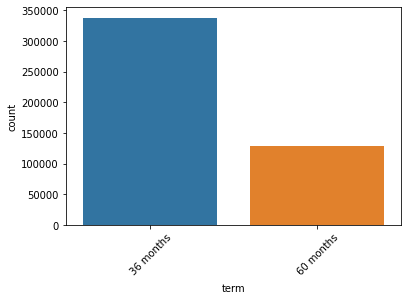

Unique categories counts: 2
Unique categories: [' 36 months' ' 60 months']
Unique value counts: {}
 36 months    337953
 60 months    128332
Name: term, dtype: int64
2. grade


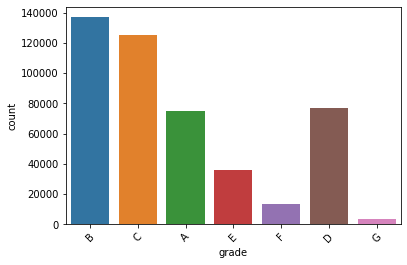

Unique categories counts: 7
Unique categories: ['B' 'C' 'A' 'E' 'F' 'D' 'G']
Unique value counts: {}
B    136929
C    125293
D     76888
A     74867
E     35757
F     13229
G      3322
Name: grade, dtype: int64
3. sub_grade


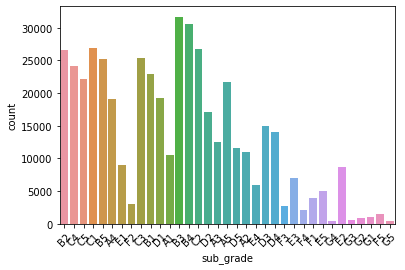

Unique categories counts: 35
Unique categories: ['B2' 'C4' 'C5' 'C1' 'B5' 'A4' 'E1' 'F2' 'C3' 'B1' 'D1' 'A1' 'B3' 'B4'
 'C2' 'D2' 'A3' 'A5' 'D5' 'A2' 'E4' 'D3' 'D4' 'F3' 'E3' 'F4' 'F1' 'E5'
 'G4' 'E2' 'G3' 'G2' 'G1' 'F5' 'G5']
Unique value counts: {}
B3    31686
B4    30505
C1    26953
C2    26740
B2    26610
C3    25317
B5    25252
C4    24105
B1    22876
C5    22178
A5    21757
D1    19261
A4    19045
D2    17046
D3    14916
D4    14099
A3    12568
D5    11566
A2    10956
A1    10541
E1     9033
E2     8669
E3     6976
E4     5992
E5     5087
F1     3940
F2     3001
F3     2708
F4     2067
F5     1513
G1     1109
G2      823
G3      583
G4      422
G5      385
Name: sub_grade, dtype: int64
4. emp_length


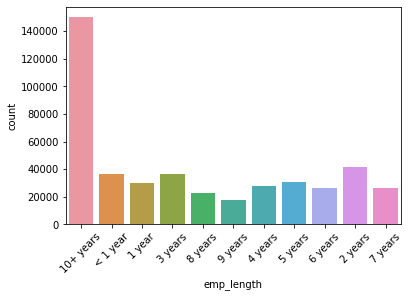

Unique categories counts: 12
Unique categories: ['10+ years' '< 1 year' '1 year' '3 years' '8 years' '9 years' '4 years'
 '5 years' '6 years' '2 years' '7 years' nan]
Unique value counts: {}
10+ years    150049
2 years       41373
3 years       36596
< 1 year      36265
5 years       30774
1 year        29622
4 years       28023
7 years       26180
6 years       26112
8 years       22395
9 years       17888
Name: emp_length, dtype: int64
5. home_ownership


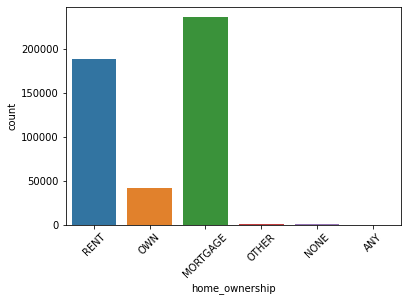

Unique categories counts: 6
Unique categories: ['RENT' 'OWN' 'MORTGAGE' 'OTHER' 'NONE' 'ANY']
Unique value counts: {}
MORTGAGE    235875
RENT        188473
OWN          41704
OTHER          182
NONE            50
ANY              1
Name: home_ownership, dtype: int64
6. verification_status


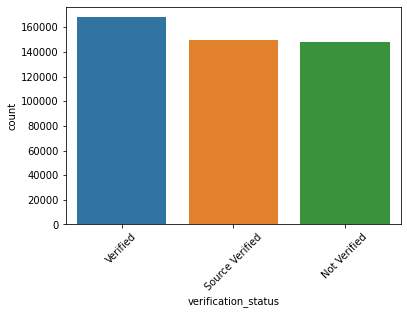

Unique categories counts: 3
Unique categories: ['Verified' 'Source Verified' 'Not Verified']
Unique value counts: {}
Verified           168055
Source Verified    149993
Not Verified       148237
Name: verification_status, dtype: int64
7. loan_status


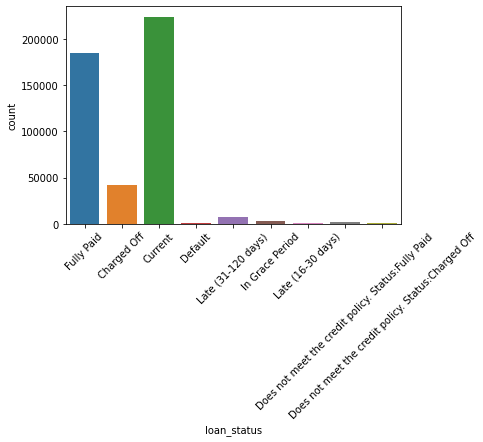

Unique categories counts: 9
Unique categories: ['Fully Paid' 'Charged Off' 'Current' 'Default' 'Late (31-120 days)'
 'In Grace Period' 'Late (16-30 days)'
 'Does not meet the credit policy. Status:Fully Paid'
 'Does not meet the credit policy. Status:Charged Off']
Unique value counts: {}
Current                                                224226
Fully Paid                                             184739
Charged Off                                             42475
Late (31-120 days)                                       6900
In Grace Period                                          3146
Does not meet the credit policy. Status:Fully Paid       1988
Late (16-30 days)                                        1218
Default                                                   832
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64
8. pymnt_plan


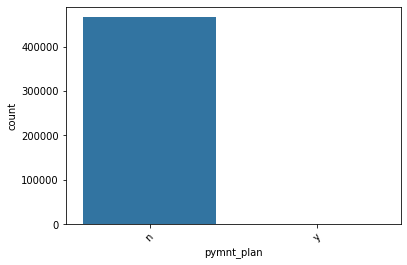

Unique categories counts: 2
Unique categories: ['n' 'y']
Unique value counts: {}
n    466276
y         9
Name: pymnt_plan, dtype: int64
9. purpose


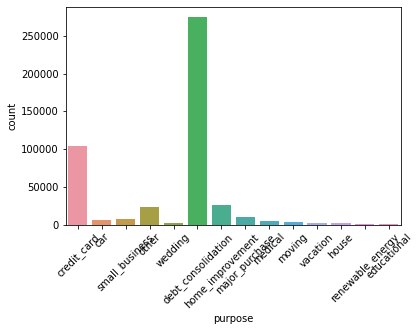

Unique categories counts: 14
Unique categories: ['credit_card' 'car' 'small_business' 'other' 'wedding'
 'debt_consolidation' 'home_improvement' 'major_purchase' 'medical'
 'moving' 'vacation' 'house' 'renewable_energy' 'educational']
Unique value counts: {}
debt_consolidation    274195
credit_card           104157
home_improvement       26537
other                  23690
major_purchase          9828
small_business          7013
car                     5397
medical                 4602
moving                  2994
vacation                2487
wedding                 2343
house                   2269
educational              422
renewable_energy         351
Name: purpose, dtype: int64
10. addr_state


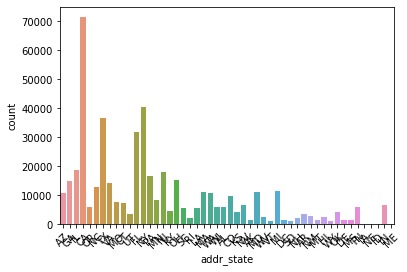

Unique categories counts: 50
Unique categories: ['AZ' 'GA' 'IL' 'CA' 'OR' 'NC' 'TX' 'VA' 'MO' 'CT' 'UT' 'FL' 'NY' 'PA'
 'MN' 'NJ' 'KY' 'OH' 'SC' 'RI' 'LA' 'MA' 'WA' 'WI' 'AL' 'CO' 'KS' 'NV'
 'AK' 'MD' 'WV' 'VT' 'MI' 'DC' 'SD' 'NH' 'AR' 'NM' 'MT' 'HI' 'WY' 'OK'
 'DE' 'MS' 'TN' 'IA' 'NE' 'ID' 'IN' 'ME']
Unique value counts: {}
CA    71450
NY    40242
TX    36439
FL    31637
IL    18612
NJ    18061
PA    16424
OH    15237
GA    14975
VA    14222
NC    12682
MI    11549
MA    11072
MD    10974
AZ    10712
WA    10517
CO     9739
MN     8158
MO     7508
CT     7204
IN     6525
NV     6519
TN     5984
OR     5949
WI     5911
AL     5853
SC     5583
LA     5489
KY     4438
KS     4190
OK     4117
AR     3488
UT     3428
NM     2588
HI     2487
WV     2412
NH     2232
RI     2050
DC     1426
MT     1396
DE     1272
AK     1251
MS     1226
WY     1128
SD      980
VT      905
IA       14
NE       14
ID       12
ME        4
Name: addr_state, dtype: int64
11. initial_list_status


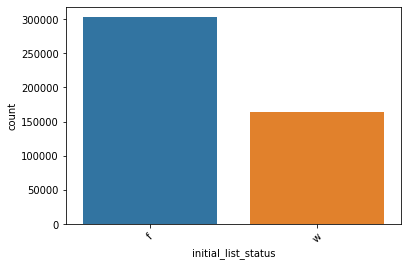

Unique categories counts: 2
Unique categories: ['f' 'w']
Unique value counts: {}
f    303005
w    163280
Name: initial_list_status, dtype: int64
12. application_type


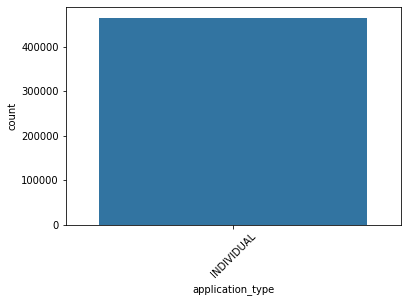

Unique categories counts: 1
Unique categories: ['INDIVIDUAL']
Unique value counts: {}
INDIVIDUAL    466285
Name: application_type, dtype: int64


In [ ]:
a = 1
for i in data_cat.drop(['emp_title', 'issue_d', 'url', 'desc', 'title', 'zip_code', 'earliest_cr_line', 'last_credit_pull_d', 'last_pymnt_d', 'next_pymnt_d'], 
                        axis =1).columns:
  print("{}. {}".format(a, i))
  sns.countplot(data= dataset, x = i)
  plt.xticks(rotation = 45)
  plt.show()

  print("Unique categories counts: {}".format(len(dataset[i].unique())))
  print("Unique categories: {}".format(dataset[i].unique()))
  print("Unique value counts: {}")
  print(dataset[i].value_counts())
  a+=1

In [ ]:
# manual check for emp_title 
emp_title = pd.DataFrame(data = dataset['emp_title'].value_counts())
emp_title.head(20)

,emp_title
Teacher,5399
Manager,4438
Registered Nurse,2316
RN,2204
Supervisor,1967
Project Manager,1624
Sales,1624
Owner,1527
Office Manager,1395
manager,1312


In [ ]:
# issue_d 
issue_d = pd.DataFrame(data = dataset['issue_d'].value_counts())
issue_d.head(5)

,issue_d
Oct-14,38782
Jul-14,29306
Nov-14,25054
May-14,19099
Apr-14,19071


In [ ]:
# url
print("Total unique value in url column: {}".format(len(dataset['url'].unique())))
print("Total unique value in desc column: {}".format(len(dataset['desc'].unique())))
print("Total unique value in title column: {}".format(len(dataset['title'].unique())))
print("Total unique value in zip_code column: {}".format(len(dataset['zip_code'].unique())))
print("Total unique value in earliest_cr_line column: {}".format(len(dataset['earliest_cr_line'].unique())))
print("Total unique value in last_credit_pull_d column: {}".format(len(dataset['last_credit_pull_d'].unique())))
print("Total unique value in last_pymnt_d column: {}".format(len(dataset['last_pymnt_d'].unique())))
print("Total unique value in next_pymnt_d column: {}".format(len(dataset['next_pymnt_d'].unique())))

Total unique value in url column: 466285
Total unique value in desc column: 124437
Total unique value in title column: 63100
Total unique value in zip_code column: 888
Total unique value in earliest_cr_line column: 665
Total unique value in last_credit_pull_d column: 104
Total unique value in last_pymnt_d column: 99
Total unique value in next_pymnt_d column: 101


# Numeric Column

1. Unnamed: 0


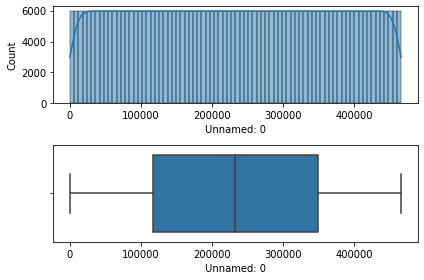

Skewtest: SkewtestResult(statistic=-4.801597605928792e-13, pvalue=0.9999999999996169)
Skew: -1.728889653436966e-15
Maximum value outside outlier = 466284
Minimum value outside outlier = 0
Total outlier = 0
----------------------------------------------------------------------------------------------------
2. id


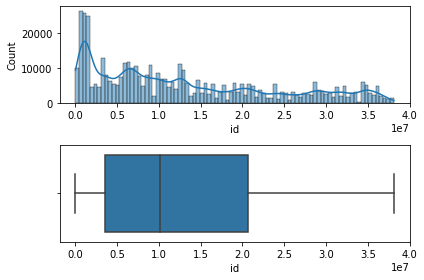

Skewtest: SkewtestResult(statistic=175.2168453532401, pvalue=0.0)
Skew: 0.6924536526701701
Maximum value outside outlier = 38098114
Minimum value outside outlier = 54734
Total outlier = 0
----------------------------------------------------------------------------------------------------
3. member_id


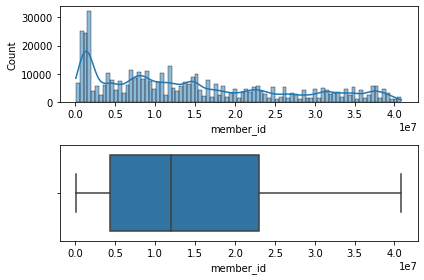

Skewtest: SkewtestResult(statistic=159.78117704013823, pvalue=0.0)
Skew: 0.6213914754204978
Maximum value outside outlier = 40860827
Minimum value outside outlier = 70473
Total outlier = 0
----------------------------------------------------------------------------------------------------
4. loan_amnt


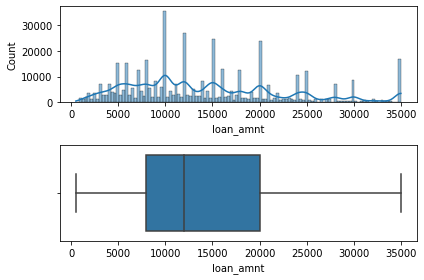

Skewtest: SkewtestResult(statistic=183.31275495331792, pvalue=0.0)
Skew: 0.7309775317402734
Maximum value outside outlier = 35000
Minimum value outside outlier = 500
Total outlier = 0
----------------------------------------------------------------------------------------------------
5. funded_amnt


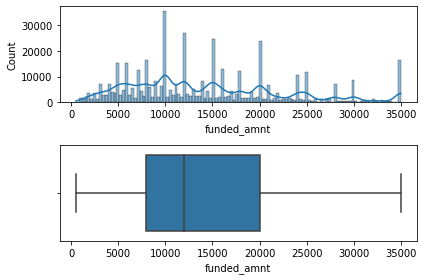

Skewtest: SkewtestResult(statistic=184.11470294843983, pvalue=0.0)
Skew: 0.7348430838668121
Maximum value outside outlier = 35000
Minimum value outside outlier = 500
Total outlier = 0
----------------------------------------------------------------------------------------------------
6. funded_amnt_inv


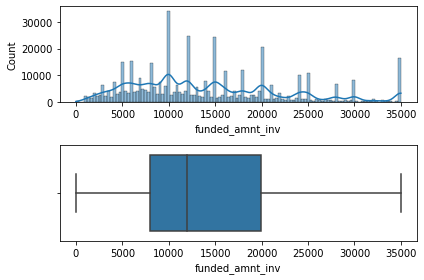

Skewtest: SkewtestResult(statistic=183.1612133831554, pvalue=0.0)
Skew: 0.730248091309873
Maximum value outside outlier = 35000.0
Minimum value outside outlier = 0.0
Total outlier = 0
----------------------------------------------------------------------------------------------------
7. int_rate


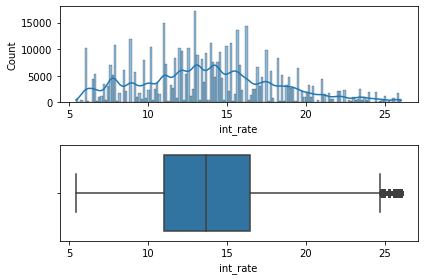

Skewtest: SkewtestResult(statistic=90.934668967136, pvalue=0.0)
Skew: 0.3349371579856011
Maximum value outside outlier = 24.7
Minimum value outside outlier = 5.42
Total outlier = 4904
----------------------------------------------------------------------------------------------------
8. installment


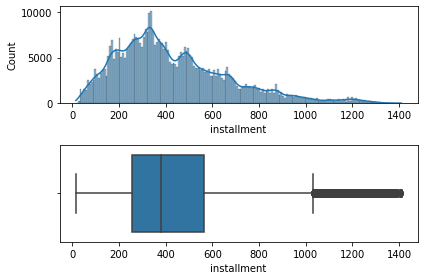

Skewtest: SkewtestResult(statistic=225.76293584871678, pvalue=0.0)
Skew: 0.9492903581823315
Maximum value outside outlier = 1031.38
Minimum value outside outlier = 15.67
Total outlier = 11711
----------------------------------------------------------------------------------------------------
9. annual_inc


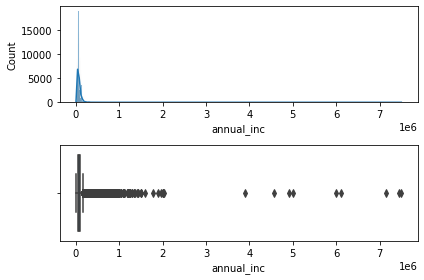

Skewtest: SkewtestResult(statistic=nan, pvalue=nan)
Skew: nan
Maximum value outside outlier = nan
Minimum value outside outlier = nan
Total outlier = 0
----------------------------------------------------------------------------------------------------
10. dti


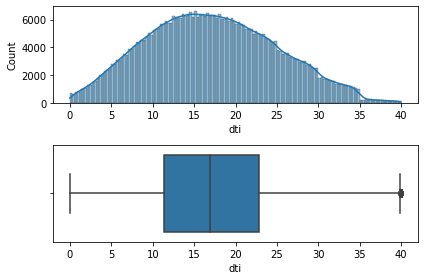

Skewtest: SkewtestResult(statistic=52.034514703367186, pvalue=0.0)
Skew: 0.18828264942483444
Maximum value outside outlier = 39.91
Minimum value outside outlier = 0.0
Total outlier = 43
----------------------------------------------------------------------------------------------------
11. delinq_2yrs


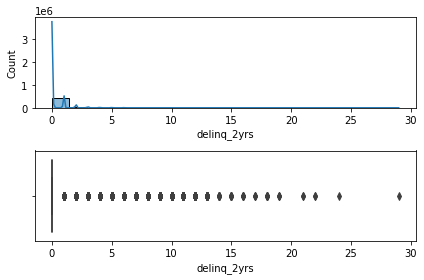

Skewtest: SkewtestResult(statistic=nan, pvalue=nan)
Skew: nan
Maximum value outside outlier = nan
Minimum value outside outlier = nan
Total outlier = 0
----------------------------------------------------------------------------------------------------
12. inq_last_6mths


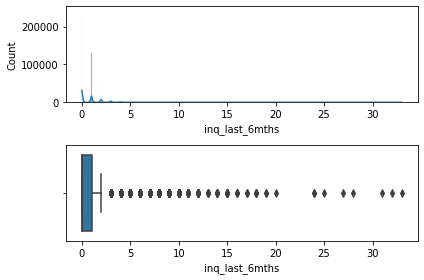

Skewtest: SkewtestResult(statistic=nan, pvalue=nan)
Skew: nan
Maximum value outside outlier = nan
Minimum value outside outlier = nan
Total outlier = 0
----------------------------------------------------------------------------------------------------
13. mths_since_last_delinq


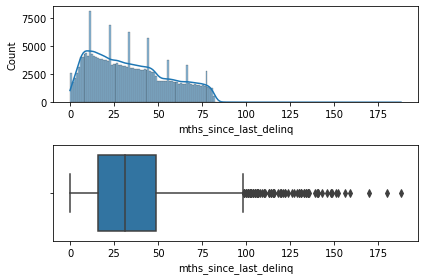

Skewtest: SkewtestResult(statistic=nan, pvalue=nan)
Skew: nan
Maximum value outside outlier = nan
Minimum value outside outlier = nan
Total outlier = 0
----------------------------------------------------------------------------------------------------
14. mths_since_last_record


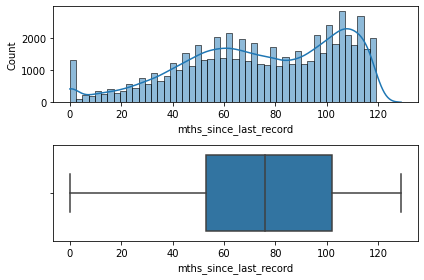

Skewtest: SkewtestResult(statistic=nan, pvalue=nan)
Skew: nan
Maximum value outside outlier = nan
Minimum value outside outlier = nan
Total outlier = 0
----------------------------------------------------------------------------------------------------
15. open_acc


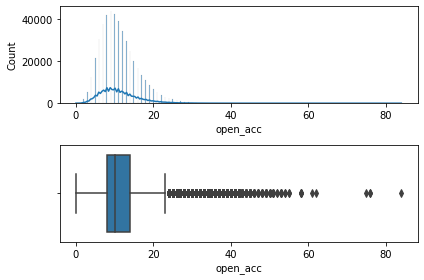

Skewtest: SkewtestResult(statistic=nan, pvalue=nan)
Skew: nan
Maximum value outside outlier = nan
Minimum value outside outlier = nan
Total outlier = 0
----------------------------------------------------------------------------------------------------
16. pub_rec


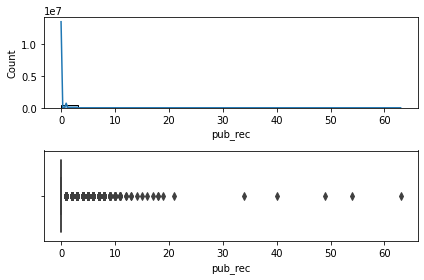

Skewtest: SkewtestResult(statistic=nan, pvalue=nan)
Skew: nan
Maximum value outside outlier = nan
Minimum value outside outlier = nan
Total outlier = 0
----------------------------------------------------------------------------------------------------
17. revol_bal


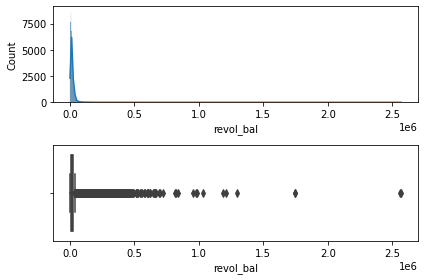

Skewtest: SkewtestResult(statistic=879.8860133930041, pvalue=0.0)
Skew: 19.476228147945964
Maximum value outside outlier = 41213
Minimum value outside outlier = 0
Total outlier = 22879
----------------------------------------------------------------------------------------------------
18. revol_util


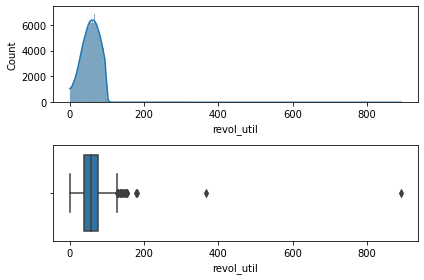

Skewtest: SkewtestResult(statistic=nan, pvalue=nan)
Skew: nan
Maximum value outside outlier = nan
Minimum value outside outlier = nan
Total outlier = 0
----------------------------------------------------------------------------------------------------
19. total_acc


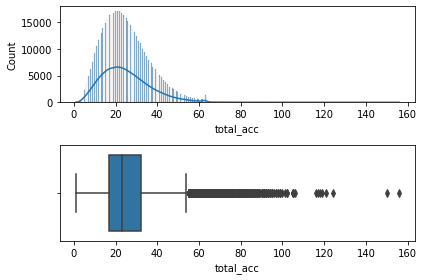

Skewtest: SkewtestResult(statistic=nan, pvalue=nan)
Skew: nan
Maximum value outside outlier = nan
Minimum value outside outlier = nan
Total outlier = 0
----------------------------------------------------------------------------------------------------
20. out_prncp


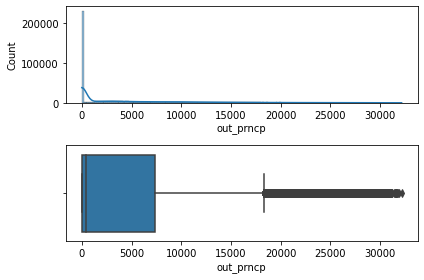

Skewtest: SkewtestResult(statistic=323.21013120905684, pvalue=0.0)
Skew: 1.59018345214046
Maximum value outside outlier = 18353.95
Minimum value outside outlier = 0.0
Total outlier = 23331
----------------------------------------------------------------------------------------------------
21. out_prncp_inv


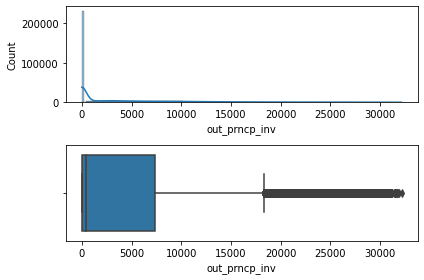

Skewtest: SkewtestResult(statistic=323.2501299609088, pvalue=0.0)
Skew: 1.5904975896980664
Maximum value outside outlier = 18345.73
Minimum value outside outlier = 0.0
Total outlier = 23381
----------------------------------------------------------------------------------------------------
22. total_pymnt


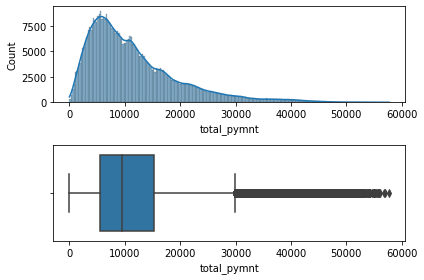

Skewtest: SkewtestResult(statistic=298.67757326925687, pvalue=0.0)
Skew: 1.406398781194567
Maximum value outside outlier = 29941.96
Minimum value outside outlier = 0.0
Total outlier = 19039
----------------------------------------------------------------------------------------------------
23. total_pymnt_inv


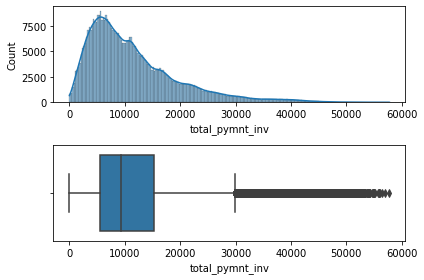

Skewtest: SkewtestResult(statistic=298.43323356363385, pvalue=0.0)
Skew: 1.4046539428532405
Maximum value outside outlier = 29829.18
Minimum value outside outlier = 0.0
Total outlier = 19052
----------------------------------------------------------------------------------------------------
24. total_rec_prncp


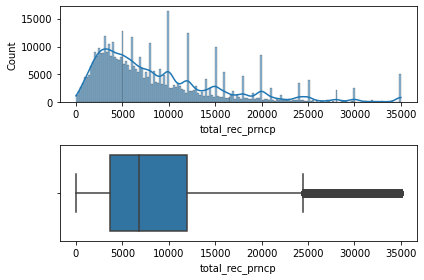

Skewtest: SkewtestResult(statistic=304.1061967041993, pvalue=0.0)
Skew: 1.4455864178017124
Maximum value outside outlier = 24434.19
Minimum value outside outlier = 0.0
Total outlier = 20649
----------------------------------------------------------------------------------------------------
25. total_rec_int


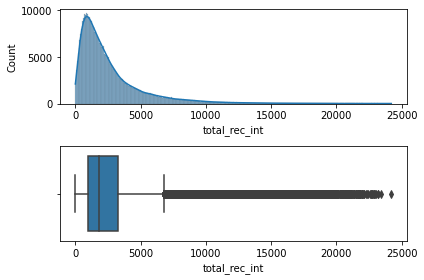

Skewtest: SkewtestResult(statistic=397.38909052496206, pvalue=0.0)
Skew: 2.268268883010098
Maximum value outside outlier = 6825.21
Minimum value outside outlier = 0.0
Total outlier = 31138
----------------------------------------------------------------------------------------------------
26. total_rec_late_fee


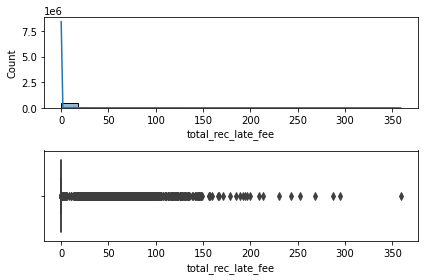

Skewtest: SkewtestResult(statistic=802.2762873221624, pvalue=0.0)
Skew: 13.843452891559188
Maximum value outside outlier = 0.0
Minimum value outside outlier = 0.0
Total outlier = 10678
----------------------------------------------------------------------------------------------------
27. recoveries


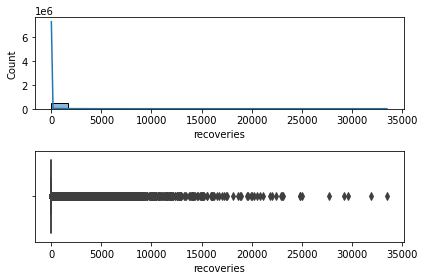

Skewtest: SkewtestResult(statistic=790.5980832515544, pvalue=0.0)
Skew: 13.149900072086655
Maximum value outside outlier = 0.0
Minimum value outside outlier = 0.0
Total outlier = 24371
----------------------------------------------------------------------------------------------------
28. collection_recovery_fee


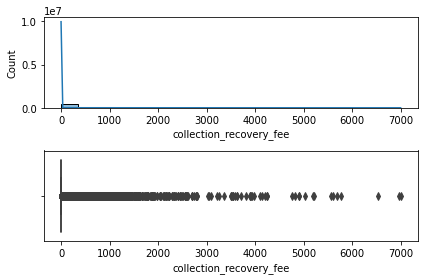

Skewtest: SkewtestResult(statistic=910.0275335270316, pvalue=0.0)
Skew: 22.23602399902316
Maximum value outside outlier = 0.0
Minimum value outside outlier = 0.0
Total outlier = 23206
----------------------------------------------------------------------------------------------------
29. last_pymnt_amnt


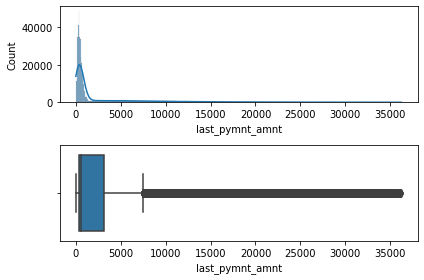

Skewtest: SkewtestResult(statistic=423.5240309455639, pvalue=0.0)
Skew: 2.5606361381374563
Maximum value outside outlier = 7499.53
Minimum value outside outlier = 0.0
Total outlier = 70346
----------------------------------------------------------------------------------------------------
30. collections_12_mths_ex_med


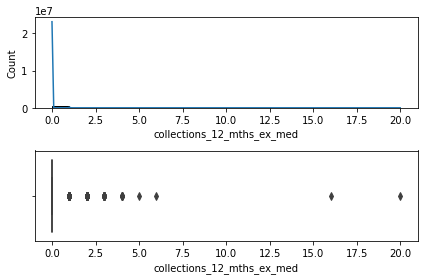

Skewtest: SkewtestResult(statistic=nan, pvalue=nan)
Skew: nan
Maximum value outside outlier = nan
Minimum value outside outlier = nan
Total outlier = 0
----------------------------------------------------------------------------------------------------
31. mths_since_last_major_derog


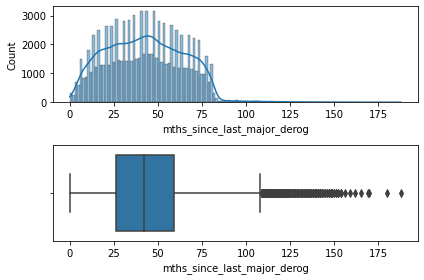

Skewtest: SkewtestResult(statistic=nan, pvalue=nan)
Skew: nan
Maximum value outside outlier = nan
Minimum value outside outlier = nan
Total outlier = 0
----------------------------------------------------------------------------------------------------
32. policy_code


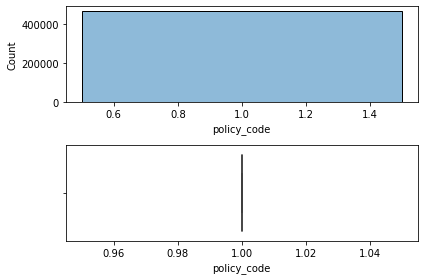

Skewtest: SkewtestResult(statistic=1.0000064333284326, pvalue=0.317307394518645)
Skew: 0.0
Maximum value outside outlier = 1
Minimum value outside outlier = 1
Total outlier = 0
----------------------------------------------------------------------------------------------------
33. annual_inc_joint


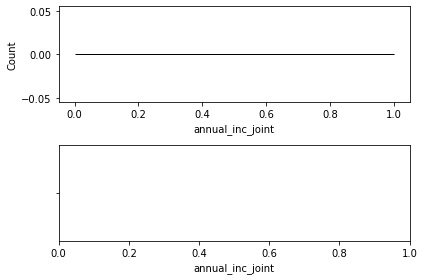

Skewtest: SkewtestResult(statistic=nan, pvalue=nan)
Skew: nan
Maximum value outside outlier = nan
Minimum value outside outlier = nan
Total outlier = 0
----------------------------------------------------------------------------------------------------
34. dti_joint


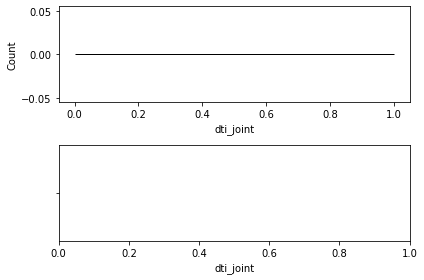

Skewtest: SkewtestResult(statistic=nan, pvalue=nan)
Skew: nan
Maximum value outside outlier = nan
Minimum value outside outlier = nan
Total outlier = 0
----------------------------------------------------------------------------------------------------
35. verification_status_joint


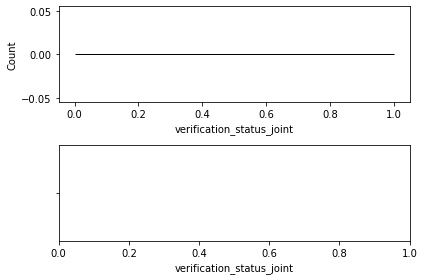

Skewtest: SkewtestResult(statistic=nan, pvalue=nan)
Skew: nan
Maximum value outside outlier = nan
Minimum value outside outlier = nan
Total outlier = 0
----------------------------------------------------------------------------------------------------
36. acc_now_delinq


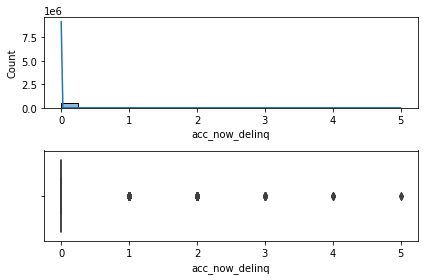

Skewtest: SkewtestResult(statistic=nan, pvalue=nan)
Skew: nan
Maximum value outside outlier = nan
Minimum value outside outlier = nan
Total outlier = 0
----------------------------------------------------------------------------------------------------
37. tot_coll_amt


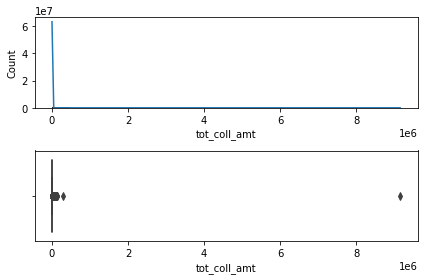

Skewtest: SkewtestResult(statistic=nan, pvalue=nan)
Skew: nan
Maximum value outside outlier = nan
Minimum value outside outlier = nan
Total outlier = 0
----------------------------------------------------------------------------------------------------
38. tot_cur_bal


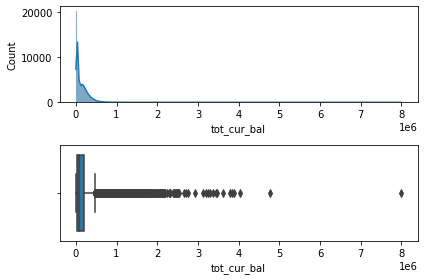

Skewtest: SkewtestResult(statistic=nan, pvalue=nan)
Skew: nan
Maximum value outside outlier = nan
Minimum value outside outlier = nan
Total outlier = 0
----------------------------------------------------------------------------------------------------
39. open_acc_6m


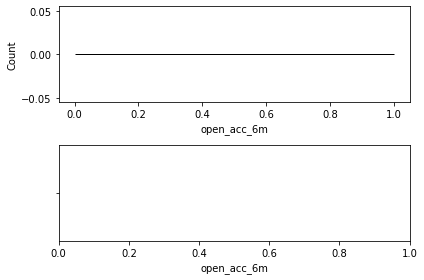

Skewtest: SkewtestResult(statistic=nan, pvalue=nan)
Skew: nan
Maximum value outside outlier = nan
Minimum value outside outlier = nan
Total outlier = 0
----------------------------------------------------------------------------------------------------
40. open_il_6m


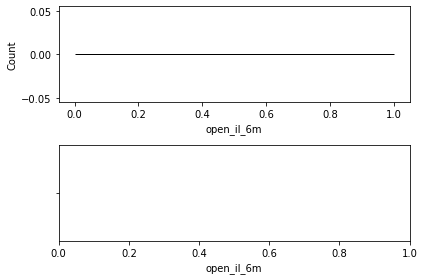

Skewtest: SkewtestResult(statistic=nan, pvalue=nan)
Skew: nan
Maximum value outside outlier = nan
Minimum value outside outlier = nan
Total outlier = 0
----------------------------------------------------------------------------------------------------
41. open_il_12m


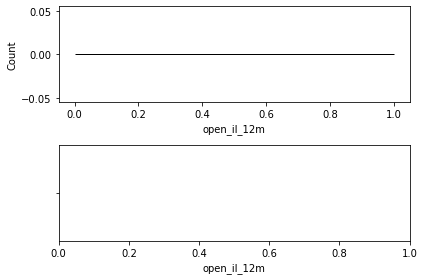

Skewtest: SkewtestResult(statistic=nan, pvalue=nan)
Skew: nan
Maximum value outside outlier = nan
Minimum value outside outlier = nan
Total outlier = 0
----------------------------------------------------------------------------------------------------
42. open_il_24m


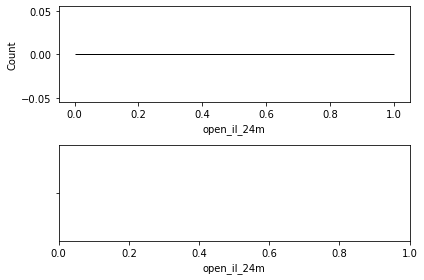

Skewtest: SkewtestResult(statistic=nan, pvalue=nan)
Skew: nan
Maximum value outside outlier = nan
Minimum value outside outlier = nan
Total outlier = 0
----------------------------------------------------------------------------------------------------
43. mths_since_rcnt_il


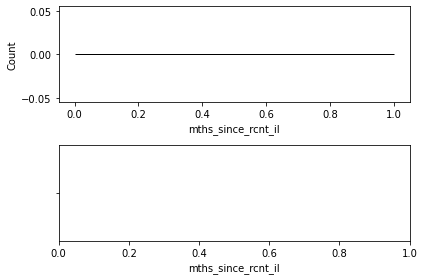

Skewtest: SkewtestResult(statistic=nan, pvalue=nan)
Skew: nan
Maximum value outside outlier = nan
Minimum value outside outlier = nan
Total outlier = 0
----------------------------------------------------------------------------------------------------
44. total_bal_il


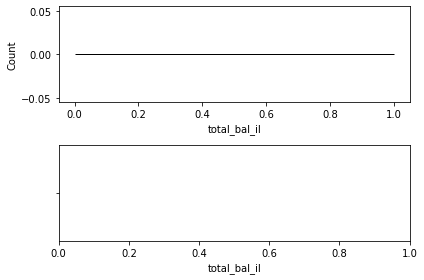

Skewtest: SkewtestResult(statistic=nan, pvalue=nan)
Skew: nan
Maximum value outside outlier = nan
Minimum value outside outlier = nan
Total outlier = 0
----------------------------------------------------------------------------------------------------
45. il_util


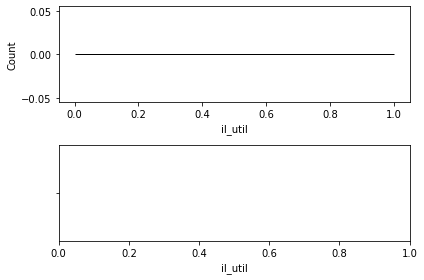

Skewtest: SkewtestResult(statistic=nan, pvalue=nan)
Skew: nan
Maximum value outside outlier = nan
Minimum value outside outlier = nan
Total outlier = 0
----------------------------------------------------------------------------------------------------
46. open_rv_12m


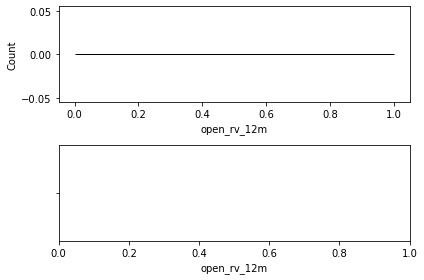

Skewtest: SkewtestResult(statistic=nan, pvalue=nan)
Skew: nan
Maximum value outside outlier = nan
Minimum value outside outlier = nan
Total outlier = 0
----------------------------------------------------------------------------------------------------
47. open_rv_24m


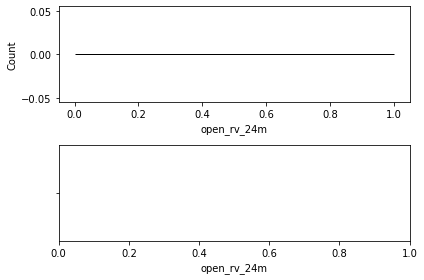

Skewtest: SkewtestResult(statistic=nan, pvalue=nan)
Skew: nan
Maximum value outside outlier = nan
Minimum value outside outlier = nan
Total outlier = 0
----------------------------------------------------------------------------------------------------
48. max_bal_bc


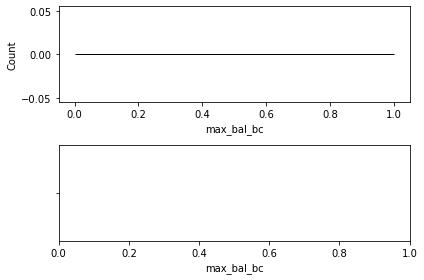

Skewtest: SkewtestResult(statistic=nan, pvalue=nan)
Skew: nan
Maximum value outside outlier = nan
Minimum value outside outlier = nan
Total outlier = 0
----------------------------------------------------------------------------------------------------
49. all_util


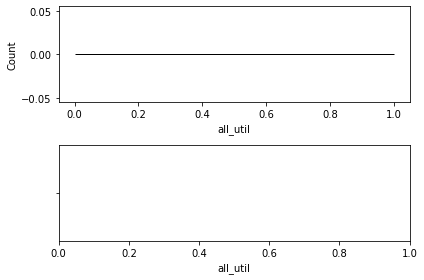

Skewtest: SkewtestResult(statistic=nan, pvalue=nan)
Skew: nan
Maximum value outside outlier = nan
Minimum value outside outlier = nan
Total outlier = 0
----------------------------------------------------------------------------------------------------
50. total_rev_hi_lim


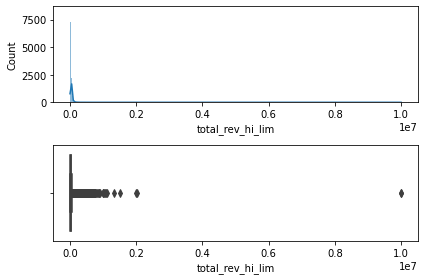

Skewtest: SkewtestResult(statistic=nan, pvalue=nan)
Skew: nan
Maximum value outside outlier = nan
Minimum value outside outlier = nan
Total outlier = 0
----------------------------------------------------------------------------------------------------
51. inq_fi


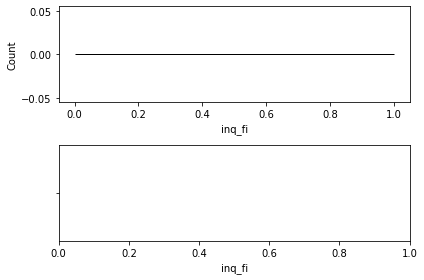

Skewtest: SkewtestResult(statistic=nan, pvalue=nan)
Skew: nan
Maximum value outside outlier = nan
Minimum value outside outlier = nan
Total outlier = 0
----------------------------------------------------------------------------------------------------
52. total_cu_tl


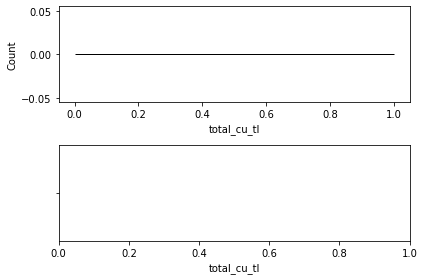

Skewtest: SkewtestResult(statistic=nan, pvalue=nan)
Skew: nan
Maximum value outside outlier = nan
Minimum value outside outlier = nan
Total outlier = 0
----------------------------------------------------------------------------------------------------
53. inq_last_12m


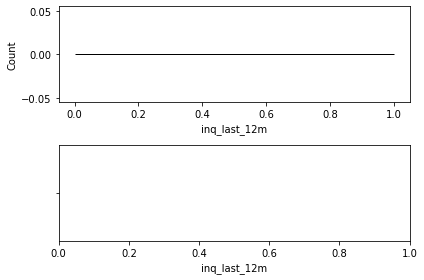

Skewtest: SkewtestResult(statistic=nan, pvalue=nan)
Skew: nan
Maximum value outside outlier = nan
Minimum value outside outlier = nan
Total outlier = 0
----------------------------------------------------------------------------------------------------


In [ ]:
a = 1 
for x in data_num.columns:
    print("{}. {}".format(a, x))
    fig, axes = plt.subplots(2, 1)
    sns.histplot(dataset[x], kde= True, ax = axes[0])
    sns.boxplot(data = dataset, x= x, ax = axes[1])
    plt.tight_layout()
    plt.show()

    print("Skewtest: {}".format(skewtest(dataset[x])))
    print("Skew: {}".format(skew(dataset[x])))
    q1 = np.percentile(dataset[x], 25)
    q3 = np.percentile(dataset[x], 75)
    iqr = q3 - q1

    upper_fence = q3 + 1.5 * iqr
    lower_fence = q1 - 1.5 * iqr 

    upper_whisker = np.max(dataset[dataset[x] <= upper_fence][x])
    lower_whisker = np.min(dataset[dataset[x] >= lower_fence][x])
    outlier = list(dataset[(dataset[x] < lower_fence) | (dataset[x] > upper_fence)][x])

    print("Maximum value outside outlier = {}".format(upper_whisker))
    print("Minimum value outside outlier = {}".format(lower_whisker))
    print("Total outlier = {}".format(len(outlier)))
    a+= 1
    print('-'*100)


In [ ]:
num_desc = data_num.describe()
positive_skew = []
negative_skew = []
normal_dist = []

for j in data_num.columns:
    if num_desc.loc['mean', j] > num_desc.loc['50%', j]:
        positive_skew.append(j)
    elif num_desc.loc['mean', j] == num_desc.loc['50%', j]:
        normal_dist.append(j)
    else:
        negative_skew.append(j)

print("Columns that have positive skew are: {}".format(positive_skew))
print("Columns that have negative skew are: {}".format(negative_skew))
print("Columns that have normal dist are: {}".format(normal_dist))

Columns that have positive skew are: ['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_bal', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim']
Columns that have negative skew are: ['mths_since_last_record', 'revol_util', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl', 'inq_last_12m']
Columns that have normal dist are: ['Unnamed: 0', 'policy_code']


In [ ]:
data_cat.head(2)

,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,earliest_cr_line,initial_list_status,last_pymnt_d,next_pymnt_d,last_credit_pull_d,application_type
0,36 months,B,B2,NaN,10+ years,RENT,Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,Jan-85,f,Jan-15,NaN,Jan-16,INDIVIDUAL
1,60 months,C,C4,Ryder,< 1 year,RENT,Source Verified,Dec-11,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,Apr-99,f,Apr-13,NaN,Sep-13,INDIVIDUAL


# Missing Value

In [ ]:
null = pd.DataFrame(data = dataset.isna().sum()/len(dataset), columns = ['%_nul'])
null_columns = []
nullup_30 = []
for x in dataset.columns:
  if null.loc[x, '%_nul'] > 0:
    null_columns.append(x)
  if null.loc[x, '%_nul'] > 0.3:
    nullup_30.append(x)


print("There are {} columns contain null values".format(len(null_columns)))
print("Total columns that have null values:")
print(null_columns)
print("Total null more than 30%:")
print(nullup_30)

There are 40 columns contain null values
Total columns that have null values:
['emp_title', 'emp_length', 'annual_inc', 'desc', 'title', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_util', 'total_acc', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m']
Total null more than 30%:
['desc', 'mths_since_last_delinq', 'mths_since_last_record', 'next_pymnt_d', 'mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m', 'm

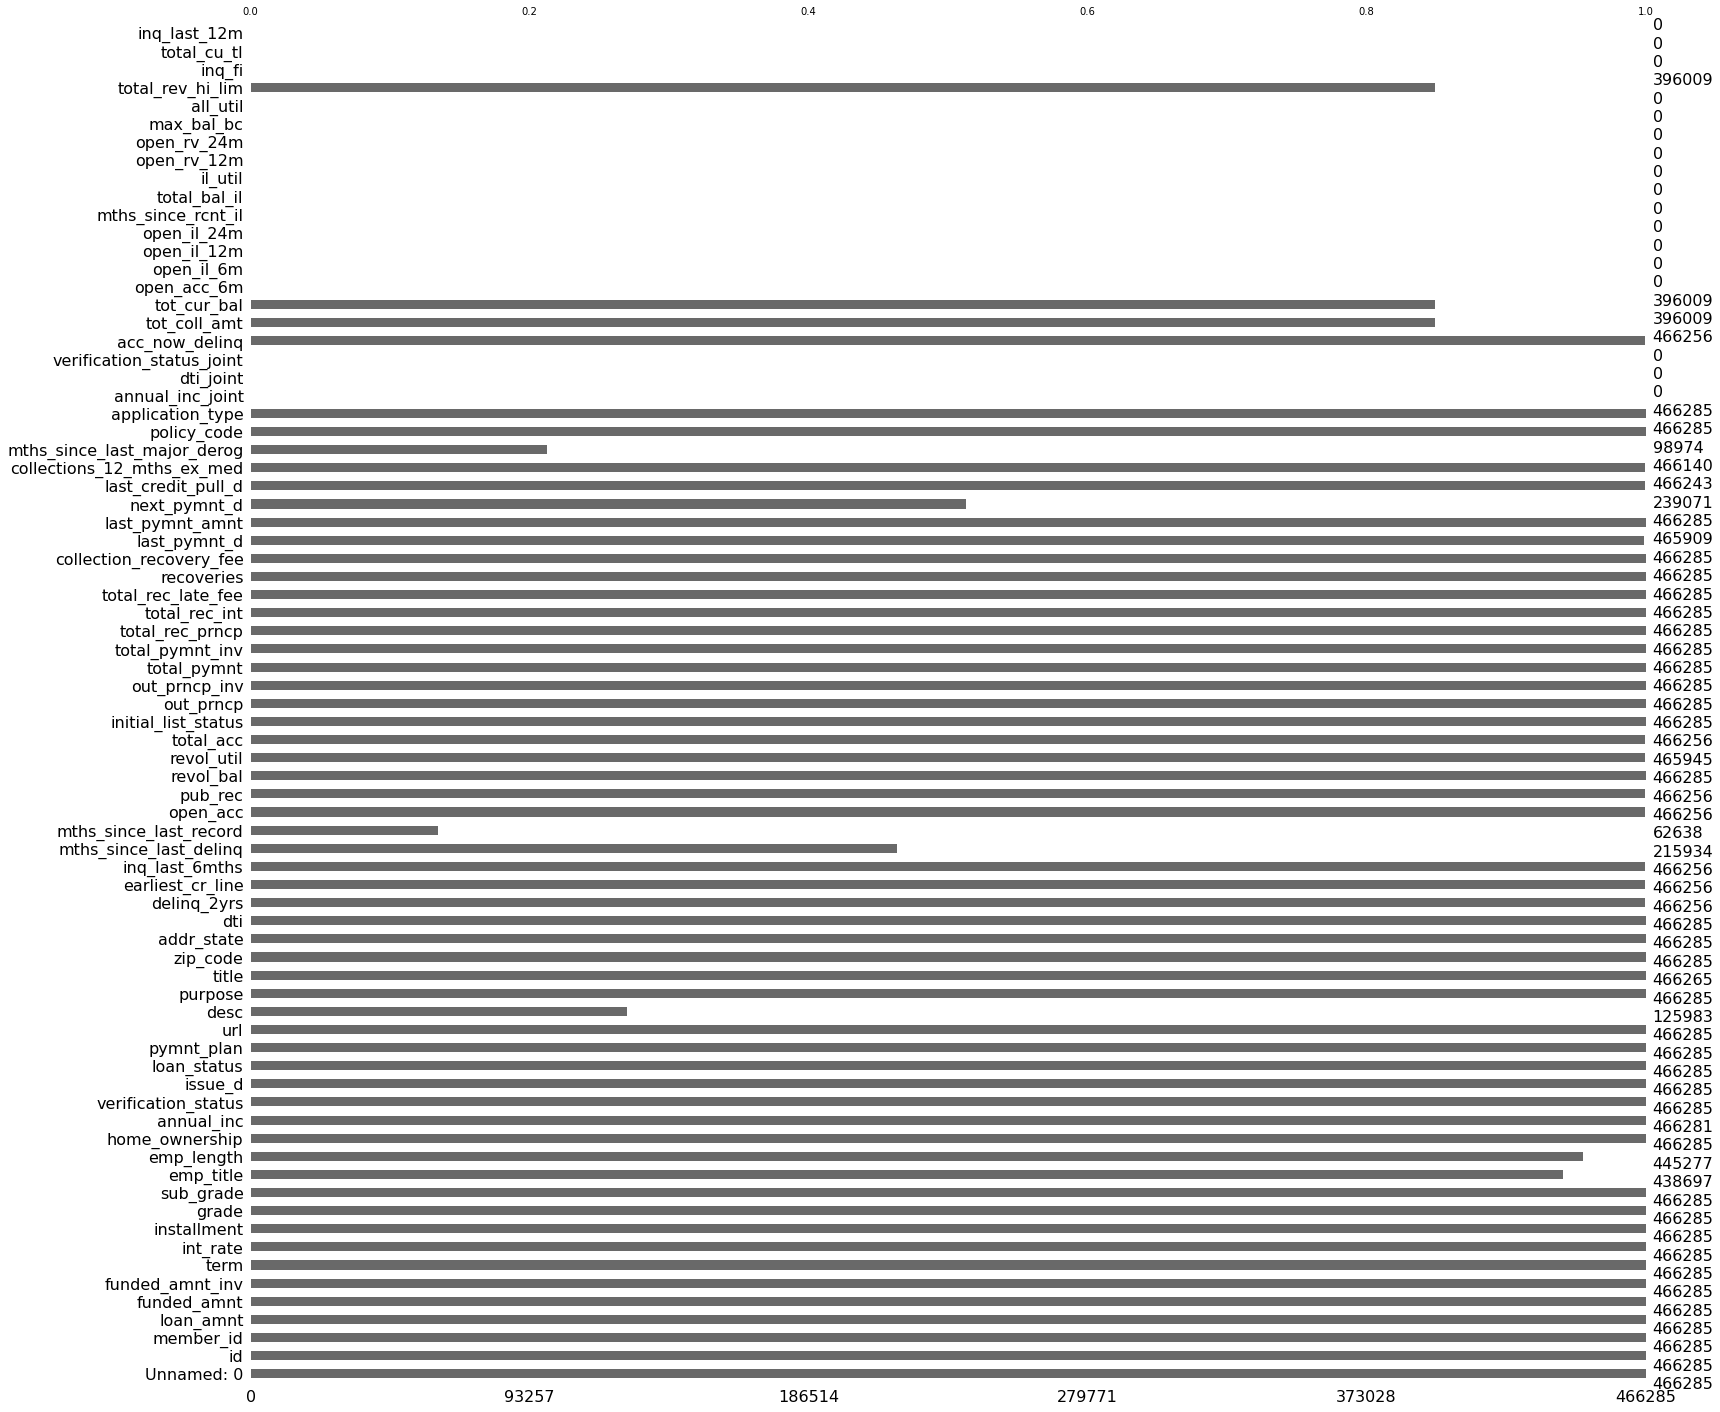

In [ ]:
msno.bar(dataset)

Kemsimpulan dan insight untuk data procerring: 
1. Untuk kolom `emp_length`diubah menjadi numerik
2. Untuk kolom `home_ownership` kategori other, none, dan any disatukan dengan other 
3. Untuk kolom `loan_status` karena kolom ini akan dijadian label maka akan dibuat kolom yang menilai apakah peminjam baik atau buruk dalam pembayarannya. 1 untuk baik dan 0 untuk buruk, kategori yang masuk kedalam 1 adalah Fully Paid, Current, Late (16 - 30 days), dan Does not meet the credict policy. Status: Fully Paid
4. Untuk kolom `pymnt_plan` karena perbandingan y:n sedikit sekali maka semua kategori dikategorikan menjadi n atau semua peminjam dianggap belum mengimplementasikan payment plan
5. Untuk kolom `purpose` hanya menggunakan kategori debt_consolidation, credit_card, home_improvement, selain itu dikategorikan sebagai other 
6. Untuk `issue_d`, `last_credit_pull_d`, `last_pymnt_d`, `next_pymnt_d` di ekstrak nama bulan
7. Kolom `Unnamed: 0` dan `policy_code` terdistribusi normal 
8. Kolom numerik yang memiliki jumlah outlier diatas 20.000 adalah `revol_bal`, `out_prncp`, `total_rec_prncp`, `total_rec_int`, `recoveries`, `collection_recovery_fee`, `last_pymnt_amnt`
9. Terdapat 40 kolom yang terdeteksi missing value. Akan dilakukan imputasi sesuai dengan persentase missing value. <= 10 % dengan simple imputer, > 10 % - 30% dengan KNN imputer, > 30% kolom akan di drop


# Data Cleaning and Pre-Processing

In [ ]:
df = dataset.copy()
df.head(2)

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-85,1.0,NaN,NaN,3.0,0.0,13648,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.0,0.00,0.00,Jan-15,171.62,NaN,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-11,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-99,5.0,NaN,NaN,3.0,0.0,1687,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.0,117.08,1.11,Apr-13,119.66,NaN,Sep-13,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# drop column that have missing value > 30%
df.drop(nullup_30, axis = 1, inplace = True)
df.shape

(466285, 53)

In [ ]:
# drop kolom id, and column that has a huge amount of unique value 
df.drop(['Unnamed: 0', 'id', 'member_id', 'emp_title', 'url', 'title', 'zip_code', 'last_pymnt_d', 'sub_grade', 'addr_state'], axis = 1, inplace= True) 

In [ ]:
# kolom emp_length
df['emp_length'] = df['emp_length'].str.replace('\+ years', '')
df['emp_length'] = df['emp_length'].str.replace('< 1 year', '0')
df['emp_length'] = df['emp_length'].str.replace(' years', '')
df['emp_length'] = df['emp_length'].str.replace(' year', '')
df['emp_length'].unique()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


array(['10', '0', '1', '3', '8', '9', '4', '5', '6', '2', '7', nan],
      dtype=object)

In [ ]:
# home_ownership
df['home_ownership'] = df['home_ownership'].apply(lambda x: 'OTHER' if (x == 'NONE') | (x == 'ANY') else x)
df['home_ownership'].unique()


array(['RENT', 'OWN', 'MORTGAGE', 'OTHER'], dtype=object)

In [ ]:
# loan_status
df['loan_status'] = df['loan_status'].apply(lambda x: 1 if (x == 'Fully Paid') | 
                    (x == "Current") | (x == "Late (16-30 days)") | 
                    (x == "Does not meet the credit policy. Status:Fully Paid") else 0)
df['loan_status'].unique()

array([1, 0])

In [ ]:
# pymnt_plan 
df['pymnt_plan'] = df['pymnt_plan'].apply(lambda x: 'n' if x == 'y' else x)
df['pymnt_plan'].unique()

array(['n'], dtype=object)

In [ ]:
# purpose 
df['purpose'] = df['purpose'].apply(lambda x: 'other' if (x =='car') | (x == 'small_business') | (x == 'other') |
                                (x == 'wedding') | (x == 'major_purchase') | (x == 'medical') | (x == 'moving') |
                                (x == 'vacation') | (x == 'house') | (x == 'renewable_energy') | (x == 'educational') else x)
df['purpose'].unique()

array(['credit_card', 'other', 'debt_consolidation', 'home_improvement'],
      dtype=object)

In [ ]:
# issue_d
df['mnth_after_issue_d'] = (pd.to_datetime('2017-12-01') - pd.to_datetime(df['issue_d'], format= '%b-%y'))//np.timedelta64(1, 'M')
df['mnth_since_last_crdt_pull'] = (pd.to_datetime('2017-12-01') - pd.to_datetime(df['last_credit_pull_d'], format= '%b-%y'))//np.timedelta64(1, 'M')
df['mnth_since_first_crdt'] = (pd.to_datetime('2017-12-01') - pd.to_datetime(df['earliest_cr_line'], format= '%b-%y'))//np.timedelta64(1, 'M')

In [ ]:
df.drop(['issue_d', 'last_credit_pull_d', 'earliest_cr_line'], axis = 1, inplace= True)

In [ ]:
# missing value after data cleaning and preprocessing
null_after = pd.DataFrame(data = df.isna().sum()/len(df), columns = ['%_null'])
null_und30 = df[null_after[null_after['%_null'] > 0].index]
print(null_und30.select_dtypes("number").columns)
print(null_und30.select_dtypes("object").columns)

Index(['annual_inc', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec',
       'revol_util', 'total_acc', 'collections_12_mths_ex_med',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim',
       'mnth_since_last_crdt_pull', 'mnth_since_first_crdt'],
      dtype='object')
Index(['emp_length'], dtype='object')


In [ ]:
print("After data cleaning and pre processing, total columns are {} and total rows are {}".format(df.shape[1], df.shape[0]))

After data cleaning and pre processing, total columns are 43 and total rows are 466285


In [ ]:
df.drop(['pymnt_plan', 'policy_code'], axis = 1, inplace = True)

# Bussines Insight

In [ ]:
df.head(1)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,mnth_after_issue_d,mnth_since_last_crdt_pull,mnth_since_first_crdt
0,5000,5000,4975.0,36 months,10.65,162.87,B,10,RENT,24000.0,Verified,1,credit_card,27.65,0.0,1.0,3.0,0.0,13648,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.0,861.07,0.0,0.0,0.0,171.62,0.0,INDIVIDUAL,0.0,NaN,NaN,NaN,72,22.0,394.0


## Persentase loan status berdasarkan grade

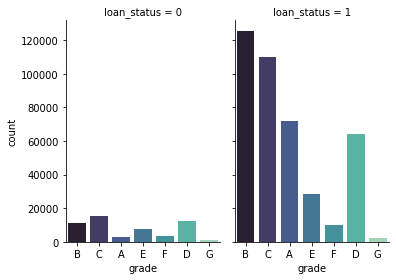

In [ ]:
sns.catplot(x="grade", col="loan_status", data=df, kind="count", height=4, aspect=.7, palette = 'mako')

In [ ]:
a_yes = pd.DataFrame(data = df[df['loan_status'] == 1].groupby(['grade']).loan_status.count().reset_index()).sort_values(by= 'loan_status', ascending= False)
a_yes['percentage'] = a_yes['loan_status']/a_yes['loan_status'].sum()
a_yes

,grade,loan_status,percentage
1,B,125489,0.304459
2,C,110009,0.266901
0,A,71794,0.174185
3,D,64327,0.156069
4,E,28351,0.068785
5,F,9853,0.023905
6,G,2348,0.005697


In [ ]:
a_no = pd.DataFrame(data = df[df['loan_status'] == 0].groupby(['grade']).loan_status.count().reset_index()).sort_values(by= 'loan_status', ascending= False)
a_no['percentage'] = a_no['loan_status']/a_no['loan_status'].sum()
a_no

,grade,loan_status,percentage
2,C,15284,0.282441
3,D,12561,0.232121
1,B,11440,0.211406
4,E,7406,0.136859
5,F,3376,0.062387
0,A,3073,0.056788
6,G,974,0.017999


# Feature Engineering

In [ ]:
X = df.drop(['loan_status'], axis = 1)
y = df['loan_status']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, stratify= y, random_state= 31)

In [ ]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(373028, 40) (373028,)
(93257, 40) (93257,)


# Data Train

In [ ]:
# split cat and numeric column for imputation missing value
xtrain_num = x_train.select_dtypes('number')
xtrain_cat = x_train.select_dtypes('object')

In [ ]:
# use ordinal encoder 
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
xtrain_cat_oe = pd.DataFrame(oe.fit_transform(xtrain_cat), columns=oe.feature_names_in_)
xtrain_concat1 = pd.concat([xtrain_num.reset_index(drop= True), xtrain_cat_oe], axis = 1)
xtrain_concat1.head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,mnth_after_issue_d,mnth_since_last_crdt_pull,mnth_since_first_crdt,term,grade,emp_length,home_ownership,verification_status,purpose,initial_list_status,application_type
0,4000,4000,4000.0,15.31,139.27,42000.0,14.51,0.0,1.0,11.0,1.0,2978,46.5,29.0,0.00,0.00,4391.190000,4391.19,4000.00,391.19,0.0,0.0,0.0,3416.30,0.0,0.0,53.0,13097.0,6400.0,44,34.0,230.0,0.0,2.0,8.0,3.0,0.0,1.0,1.0,0.0
1,2700,2700,2700.0,5.79,81.89,47500.0,19.81,0.0,1.0,14.0,0.0,13159,18.3,32.0,0.00,0.00,2946.190273,2946.19,2700.00,246.19,0.0,0.0,0.0,97.20,0.0,0.0,NaN,NaN,NaN,80,43.0,304.0,0.0,0.0,9.0,0.0,0.0,1.0,0.0,0.0
2,10000,10000,10000.0,12.99,336.90,85000.0,13.25,0.0,2.0,17.0,0.0,19456,59.3,42.0,3475.74,3475.74,8422.500000,8422.50,6524.26,1898.24,0.0,0.0,0.0,336.90,0.0,0.0,0.0,201385.0,32800.0,48,22.0,321.0,0.0,1.0,NaN,0.0,2.0,0.0,1.0,0.0
3,16000,16000,16000.0,14.33,549.42,185000.0,16.78,0.0,2.0,18.0,0.0,60755,75.9,58.0,3166.48,3166.48,16476.860000,16476.86,12833.52,3643.34,0.0,0.0,0.0,549.42,0.0,0.0,0.0,119677.0,81000.0,53,29.0,438.0,0.0,2.0,2.0,0.0,2.0,0.0,0.0,0.0
4,20000,20000,20000.0,8.39,630.34,60000.0,21.00,1.0,1.0,15.0,0.0,9645,68.4,25.0,10070.04,10070.04,11976.460000,11976.46,9929.96,2046.50,0.0,0.0,0.0,630.34,0.0,0.0,0.0,225610.0,14100.0,43,22.0,185.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [ ]:
imp_median = SimpleImputer(strategy="median")
imp_modus = SimpleImputer(strategy="most_frequent")

In [ ]:
# numeric column with median 
xtrain_concat1["annual_inc"] = imp_median.fit_transform(np.array(xtrain_concat1["annual_inc"]).reshape(-1,1))
xtrain_concat1["delinq_2yrs"] = imp_median.fit_transform(np.array(xtrain_concat1["delinq_2yrs"]).reshape(-1,1))
xtrain_concat1["inq_last_6mths"] = imp_median.fit_transform(np.array(xtrain_concat1["inq_last_6mths"]).reshape(-1,1))
xtrain_concat1["open_acc"] = imp_median.fit_transform(np.array(xtrain_concat1["open_acc"]).reshape(-1,1))
xtrain_concat1["pub_rec"] = imp_median.fit_transform(np.array(xtrain_concat1["pub_rec"]).reshape(-1,1))
xtrain_concat1["revol_util"] = imp_median.fit_transform(np.array(xtrain_concat1["revol_util"]).reshape(-1,1))
xtrain_concat1["total_acc"] = imp_median.fit_transform(np.array(xtrain_concat1["total_acc"]).reshape(-1,1))
xtrain_concat1["collections_12_mths_ex_med"] = imp_median.fit_transform(np.array(xtrain_concat1["collections_12_mths_ex_med"]).reshape(-1,1))
xtrain_concat1["acc_now_delinq"] = imp_median.fit_transform(np.array(xtrain_concat1["acc_now_delinq"]).reshape(-1,1))
xtrain_concat1["tot_coll_amt"] = imp_median.fit_transform(np.array(xtrain_concat1["tot_coll_amt"]).reshape(-1,1))
xtrain_concat1["tot_cur_bal"] = imp_median.fit_transform(np.array(xtrain_concat1["tot_cur_bal"]).reshape(-1,1))
xtrain_concat1["total_rev_hi_lim"] = imp_median.fit_transform(np.array(xtrain_concat1["total_rev_hi_lim"]).reshape(-1,1))
xtrain_concat1["mnth_since_last_crdt_pull"] = imp_median.fit_transform(np.array(xtrain_concat1["mnth_since_last_crdt_pull"]).reshape(-1,1))
xtrain_concat1["mnth_since_first_crdt"] = imp_median.fit_transform(np.array(xtrain_concat1["mnth_since_first_crdt"]).reshape(-1,1))

In [ ]:
# category column with modus 
xtrain_concat1["emp_length"] = imp_modus.fit_transform(np.array(xtrain_concat1["emp_length"]).reshape(-1,1))

In [ ]:
# inverse
xtrain_concat1[oe.feature_names_in_] = oe.inverse_transform(xtrain_concat1[oe.feature_names_in_])
xtrain_concat1.head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,mnth_after_issue_d,mnth_since_last_crdt_pull,mnth_since_first_crdt,term,grade,emp_length,home_ownership,verification_status,purpose,initial_list_status,application_type
0,4000,4000,4000.0,15.31,139.27,42000.0,14.51,0.0,1.0,11.0,1.0,2978,46.5,29.0,0.00,0.00,4391.190000,4391.19,4000.00,391.19,0.0,0.0,0.0,3416.30,0.0,0.0,53.0,13097.0,6400.0,44,34.0,230.0,36 months,C,7,RENT,Not Verified,debt_consolidation,w,INDIVIDUAL
1,2700,2700,2700.0,5.79,81.89,47500.0,19.81,0.0,1.0,14.0,0.0,13159,18.3,32.0,0.00,0.00,2946.190273,2946.19,2700.00,246.19,0.0,0.0,0.0,97.20,0.0,0.0,0.0,81402.5,22800.0,80,43.0,304.0,36 months,A,8,MORTGAGE,Not Verified,debt_consolidation,f,INDIVIDUAL
2,10000,10000,10000.0,12.99,336.90,85000.0,13.25,0.0,2.0,17.0,0.0,19456,59.3,42.0,3475.74,3475.74,8422.500000,8422.50,6524.26,1898.24,0.0,0.0,0.0,336.90,0.0,0.0,0.0,201385.0,32800.0,48,22.0,321.0,36 months,B,10,MORTGAGE,Verified,credit_card,w,INDIVIDUAL
3,16000,16000,16000.0,14.33,549.42,185000.0,16.78,0.0,2.0,18.0,0.0,60755,75.9,58.0,3166.48,3166.48,16476.860000,16476.86,12833.52,3643.34,0.0,0.0,0.0,549.42,0.0,0.0,0.0,119677.0,81000.0,53,29.0,438.0,36 months,C,10,MORTGAGE,Verified,credit_card,f,INDIVIDUAL
4,20000,20000,20000.0,8.39,630.34,60000.0,21.00,1.0,1.0,15.0,0.0,9645,68.4,25.0,10070.04,10070.04,11976.460000,11976.46,9929.96,2046.50,0.0,0.0,0.0,630.34,0.0,0.0,0.0,225610.0,14100.0,43,22.0,185.0,36 months,A,0,MORTGAGE,Source Verified,debt_consolidation,f,INDIVIDUAL


In [ ]:
xtrain_imp_num = xtrain_concat1.select_dtypes('number')
xtrain_imp_cat = xtrain_concat1.select_dtypes('object')

In [ ]:
# one hot encoder 
ohe = OneHotEncoder(handle_unknown='ignore')
xtrain_ohe = pd.DataFrame(ohe.fit_transform(xtrain_imp_cat).toarray(), columns=ohe.get_feature_names_out(xtrain_imp_cat.columns))

In [ ]:
# robust scaler
rs = RobustScaler()
xtrain_scaler = pd.DataFrame(rs.fit_transform(xtrain_imp_num), columns = rs.feature_names_in_)

In [ ]:
xtrain_imp_num.to_csv("train_imputed.csv", index = False)

In [ ]:
xtrain_trans = pd.concat([xtrain_ohe, xtrain_scaler], axis = 1)
xtrain_trans.head()

,term_ 36 months,term_ 60 months,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,emp_length_0,emp_length_1,emp_length_10,emp_length_2,emp_length_3,emp_length_4,emp_length_5,emp_length_6,emp_length_7,emp_length_8,emp_length_9,home_ownership_MORTGAGE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_other,initial_list_status_f,initial_list_status_w,application_type_INDIVIDUAL,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,mnth_after_issue_d,mnth_since_last_crdt_pull,mnth_since_first_crdt
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,-0.666667,-0.666667,-0.669456,0.300000,-0.779297,-0.481541,-0.208042,0.0,1.0,0.166667,1.0,-0.631034,-0.309859,0.333333,-0.064354,-0.064330,-0.515817,-0.510304,-0.339199,-0.609269,0.0,0.0,0.0,1.000609,0.0,0.0,53.0,-0.451865,-0.849741,-0.1250,4.000000,0.049020
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,-0.775000,-0.775000,-0.778243,-1.430909,-0.964679,-0.355423,0.255245,0.0,1.0,0.666667,0.0,0.100359,-1.104225,0.533333,-0.064354,-0.064330,-0.663994,-0.658805,-0.496104,-0.671012,0.0,0.0,0.0,-0.156423,0.0,0.0,0.0,0.000000,0.000000,2.1250,7.000000,0.774510
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.166667,-0.166667,-0.167364,-0.121818,-0.140798,0.504471,-0.318182,0.0,2.0,1.166667,0.0,0.552730,0.050704,1.200000,0.407558,0.407740,-0.102426,-0.096010,-0.034531,0.032456,0.0,0.0,0.0,-0.072864,0.0,0.0,0.0,0.793727,0.518135,0.1250,0.000000,0.941176
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.333333,0.333333,0.334728,0.121818,0.545808,2.797524,-0.009615,0.0,2.0,1.333333,0.0,3.519612,0.518310,2.266667,0.365569,0.365736,0.723508,0.731728,0.726973,0.775545,0.0,0.0,0.0,0.001220,0.0,0.0,0.0,0.253199,3.015544,0.4375,2.333333,2.088235
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.666667,0.666667,0.669456,-0.958182,0.807243,-0.068792,0.359266,1.0,1.0,0.833333,0.0,-0.152083,0.307042,0.066667,1.302888,1.303369,0.262015,0.269226,0.376524,0.095587,0.0,0.0,0.0,0.029429,0.0,0.0,0.0,0.953984,-0.450777,-0.1875,0.000000,-0.392157


In [ ]:
# check if there is missing value 
xtrain_trans.isna().any().any()

False

In [ ]:
xtrain_trans.shape

(373028, 66)

# Multicolinearity Reduction

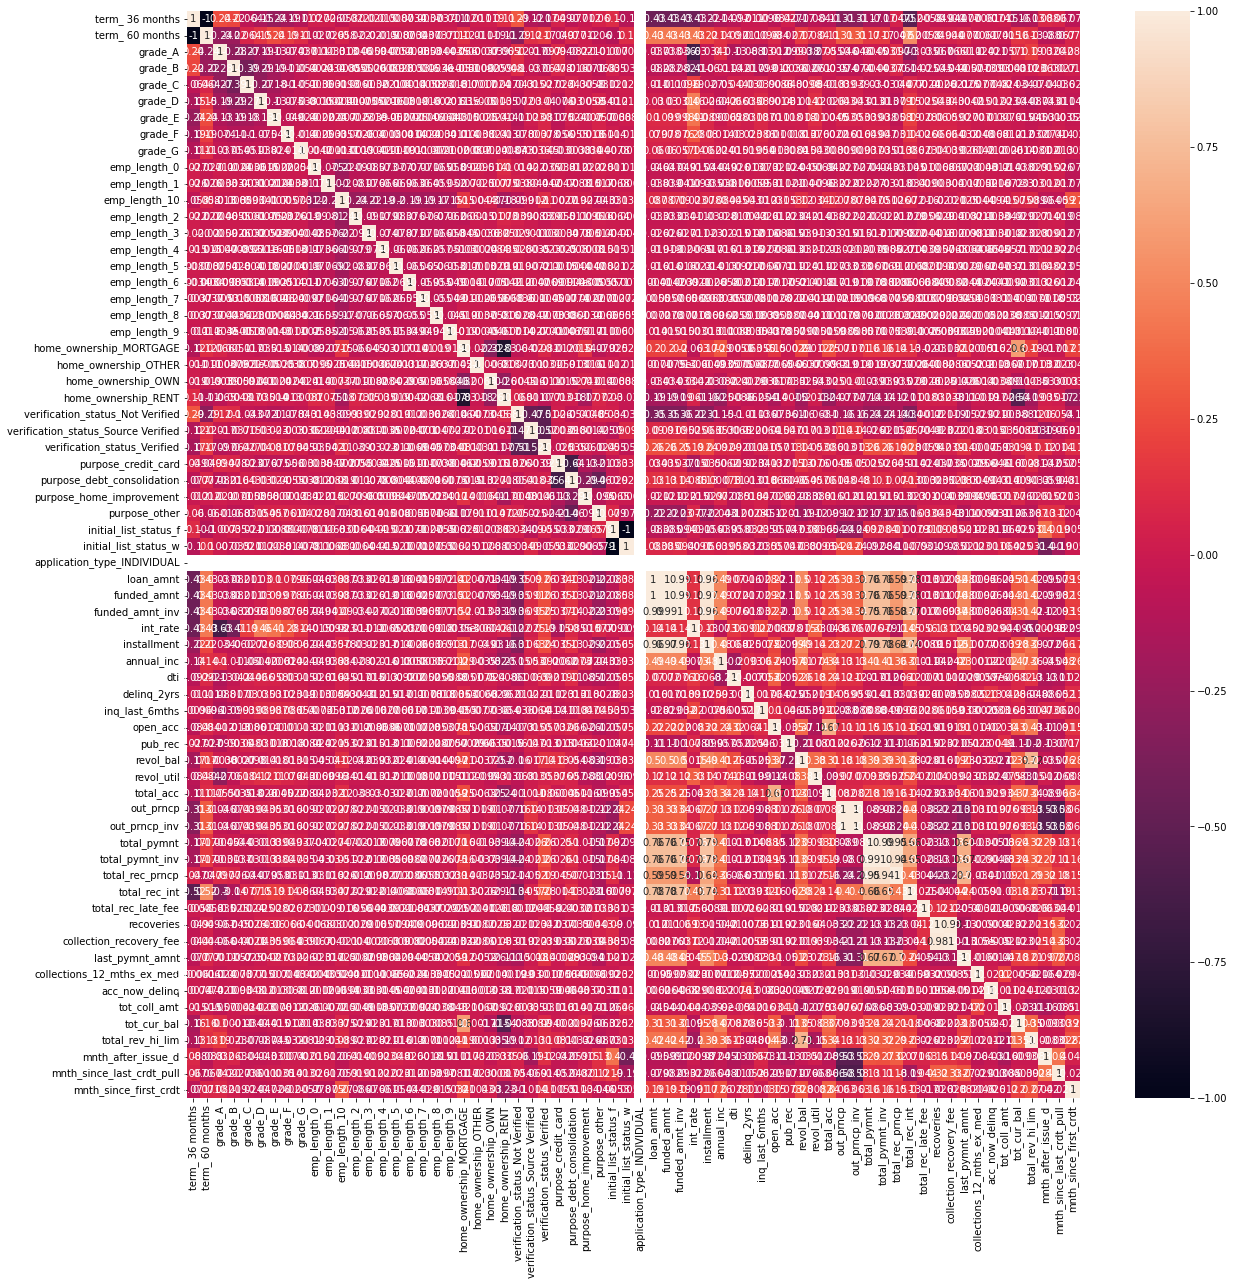

In [ ]:
corr_ = xtrain_trans.corr(method = 'spearman')
plt.figure(figsize=(20,20))
sns.heatmap(corr_, annot = True)

In [ ]:
# choose columns to drop
threshold = 0.65
couple = []
drop = []
for idx in corr_.index:
  for col in corr_.columns:
    if idx != col:
       if [col, idx] not in couple:
         couple.append([idx, col])
         if np.abs(corr_.loc[idx, col]) > threshold:
           if idx not in drop:
             drop.append(idx)

print("{} columns drop after multicolinearity reduction".format(len(drop)))

14 columns drop after multicolinearity reduction


In [ ]:
drop

['term_ 36 months',
 'home_ownership_MORTGAGE',
 'initial_list_status_f',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'installment',
 'open_acc',
 'revol_bal',
 'out_prncp',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'recoveries']

In [ ]:
xtrain_trans_mr = xtrain_trans.drop(drop, axis = 1)
# after
xtrain_trans_mr.shape

(373028, 52)

# KBest 

In [ ]:
np.random.seed(42)
kbest = SelectKBest(score_func=mutual_info_classif, k=17)
kbest.fit(xtrain_trans_mr, y_train)

SelectKBest(k=17, score_func=<function mutual_info_classif at 0x7f3502f6cef0>)

In [ ]:
final_col = xtrain_trans_mr.columns[kbest.get_support()]
xtrain_trans_sel = xtrain_trans_mr.loc[:,final_col]
xtrain_trans_sel.head()

,grade_A,grade_B,emp_length_10,home_ownership_RENT,verification_status_Not Verified,verification_status_Verified,purpose_debt_consolidation,initial_list_status_w,application_type_INDIVIDUAL,int_rate,inq_last_6mths,out_prncp_inv,total_rec_int,total_rec_late_fee,collection_recovery_fee,last_pymnt_amnt,mnth_since_last_crdt_pull
0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.300000,1.0,-0.064330,-0.609269,0.0,0.0,1.000609,4.000000
1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,-1.430909,1.0,-0.064330,-0.671012,0.0,0.0,-0.156423,7.000000
2,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,-0.121818,2.0,0.407740,0.032456,0.0,0.0,-0.072864,0.000000
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.121818,2.0,0.365736,0.775545,0.0,0.0,0.001220,2.333333
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-0.958182,1.0,1.303369,0.095587,0.0,0.0,0.029429,0.000000


# Data Test

In [ ]:
xtest_num = x_test.select_dtypes('number').reset_index(drop=True)
xtest_cat = x_test.select_dtypes('object')

In [ ]:
xtest_oe = pd.DataFrame(oe.transform(xtest_cat), columns=xtest_cat.columns)

In [ ]:
xtest_concat1 = pd.concat([xtest_num, xtest_oe], axis = 1)
xtest_concat1.shape

(93257, 40)

In [ ]:
# numeric column with median 
xtest_concat1["annual_inc"] = imp_median.transform(np.array(xtest_concat1["annual_inc"]).reshape(-1,1))
xtest_concat1["delinq_2yrs"] = imp_median.transform(np.array(xtest_concat1["delinq_2yrs"]).reshape(-1,1))
xtest_concat1["inq_last_6mths"] = imp_median.transform(np.array(xtest_concat1["inq_last_6mths"]).reshape(-1,1))
xtest_concat1["open_acc"] = imp_median.transform(np.array(xtest_concat1["open_acc"]).reshape(-1,1))
xtest_concat1["pub_rec"] = imp_median.transform(np.array(xtest_concat1["pub_rec"]).reshape(-1,1))
xtest_concat1["revol_util"] = imp_median.transform(np.array(xtest_concat1["revol_util"]).reshape(-1,1))
xtest_concat1["total_acc"] = imp_median.transform(np.array(xtest_concat1["total_acc"]).reshape(-1,1))
xtest_concat1["collections_12_mths_ex_med"] = imp_median.transform(np.array(xtest_concat1["collections_12_mths_ex_med"]).reshape(-1,1))
xtest_concat1["acc_now_delinq"] = imp_median.transform(np.array(xtest_concat1["acc_now_delinq"]).reshape(-1,1))
xtest_concat1["tot_coll_amt"] = imp_median.transform(np.array(xtest_concat1["tot_coll_amt"]).reshape(-1,1))
xtest_concat1["tot_cur_bal"] = imp_median.transform(np.array(xtest_concat1["tot_cur_bal"]).reshape(-1,1))
xtest_concat1["total_rev_hi_lim"] = imp_median.transform(np.array(xtest_concat1["total_rev_hi_lim"]).reshape(-1,1))
xtest_concat1["mnth_since_last_crdt_pull"] = imp_median.transform(np.array(xtest_concat1["mnth_since_last_crdt_pull"]).reshape(-1,1))
xtest_concat1["mnth_since_first_crdt"] = imp_median.transform(np.array(xtest_concat1["mnth_since_first_crdt"]).reshape(-1,1))

In [ ]:
# category column with modus 
xtest_concat1["emp_length"] = imp_modus.transform(np.array(xtest_concat1["emp_length"]).reshape(-1,1))

In [ ]:
xtest_concat1[xtest_cat.columns] = oe.inverse_transform(xtest_concat1[xtest_cat.columns])
xtest_concat1.head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,mnth_after_issue_d,mnth_since_last_crdt_pull,mnth_since_first_crdt,term,grade,emp_length,home_ownership,verification_status,purpose,initial_list_status,application_type
0,35000,35000,35000.0,19.52,917.97,120000.0,19.73,0.0,0.0,16.0,2.0,13119,61.0,43.0,27310.63,27310.63,17441.43000,17441.43,7689.37,9752.06,0.0,0.0,0.000,917.97,0.0,0.0,118.0,448217.0,21500.0,42,22.0,240.0,60 months,E,5,MORTGAGE,Verified,debt_consolidation,w,INDIVIDUAL
1,29850,29850,29750.0,19.99,790.68,95000.0,25.18,1.0,0.0,7.0,0.0,22874,98.6,33.0,23360.61,23282.35,15022.92000,14972.59,6489.39,8533.53,0.0,0.0,0.000,790.68,0.0,0.0,0.0,318692.0,23200.0,43,22.0,288.0,60 months,E,10,RENT,Verified,debt_consolidation,w,INDIVIDUAL
2,12000,12000,11750.0,12.12,399.26,50000.0,20.14,0.0,0.0,10.0,0.0,34486,81.9,36.0,0.00,0.00,14324.08483,14025.67,12000.00,2324.08,0.0,0.0,0.000,352.24,0.0,0.0,0.0,34486.0,42100.0,61,22.0,260.0,36 months,B,5,RENT,Not Verified,credit_card,f,INDIVIDUAL
3,10000,10000,10000.0,15.31,348.18,30000.0,6.48,1.0,0.0,4.0,0.0,4081,46.9,5.0,4437.93,4437.93,7659.96000,7659.96,5562.07,2097.89,0.0,0.0,0.000,348.18,0.0,0.0,0.0,4081.0,8700.0,45,22.0,164.0,36 months,C,4,MORTGAGE,Not Verified,home_improvement,f,INDIVIDUAL
4,22000,22000,22000.0,12.99,500.46,75000.0,16.37,0.0,0.0,13.0,1.0,5866,46.2,23.0,0.00,0.00,7539.88000,7539.88,2179.73,1823.95,0.0,3536.2,636.516,500.46,0.0,0.0,0.0,262087.0,12700.0,41,28.0,198.0,60 months,C,10,MORTGAGE,Source Verified,debt_consolidation,f,INDIVIDUAL


In [ ]:
xtest_imp_num = xtest_concat1.select_dtypes('number')
xtest_imp_cat = xtest_concat1.select_dtypes('object')

In [ ]:
xtest_imp_scaled = pd.DataFrame(rs.transform(xtest_imp_num), columns= xtest_imp_num.columns)
xtest_imp_ohe = pd.DataFrame(ohe.transform(xtest_imp_cat).toarray(), columns=ohe.get_feature_names_out(xtest_imp_cat.columns))

In [ ]:
xtest_trans = pd.concat([xtest_imp_ohe, xtest_imp_scaled], axis=1)
xtest_trans.isna().any().any()

False

In [ ]:
xtest_trans_sel =xtest_trans[xtrain_trans_sel.columns]
xtest_trans_sel.shape

(93257, 17)

# **MACHINE LEARNING**

In [ ]:
y_train.value_counts(normalize=True)

1    0.883947
0    0.116053
Name: loan_status, dtype: float64

In [ ]:
print(xtrain_trans_sel.shape, y_train.shape)
print(xtest_trans_sel.shape, y_test.shape)

(373028, 17) (373028,)
(93257, 17) (93257,)


**1. Logistic Regression**

In [ ]:
# Default 
lr = LogisticRegression(random_state = 42)
lr.fit(xtrain_trans_sel, y_train)

LogisticRegression(random_state=42)

In [ ]:
# lr tunning 
param_grid = {'penalty': ['l1', 'l2', 'none'],
              'solver': ['lbfgs', 'saga']}
gscv_lr = GridSearchCV(lr, param_grid = param_grid, cv= 5)

In [ ]:
gscv_lr.fit(xtrain_trans_sel, y_train)

In [ ]:
gscv_lr.best_params_

{'penalty': 'none', 'solver': 'lbfgs'}

In [ ]:
lr_opt = LogisticRegression(random_state=42, penalty='l2', solver= 'lbfgs')
lr_opt.fit(xtrain_trans_sel, y_train)

LogisticRegression(random_state=42)

In [ ]:
# score lr tunning 
merg([result_met(lr, xtrain_trans_sel, y_train, 'lr_train_def'),
      result_met(lr, xtest_trans_sel, y_test, 'lr_test_def'),
      result_met(lr_opt, xtrain_trans_sel, y_train, 'lr_train_opt'),
      result_met(lr_opt, xtest_trans_sel, y_test, 'lr_test_opt')])

,precision,recall,f1_score,accuracy,npv,tnr,fpr
lr_train_def,0.93,1.0,0.96,0.93,0.97,0.45,0.55
lr_test_def,0.93,1.0,0.96,0.93,0.97,0.45,0.55
lr_train_opt,0.93,1.0,0.96,0.93,0.97,0.45,0.55
lr_test_opt,0.93,1.0,0.96,0.93,0.97,0.45,0.55


Score antara lr dan lr tunning sama

**Decission Tree**

In [ ]:
# dt default
dt = DecisionTreeClassifier()
dt.fit(xtrain_trans_sel, y_train)

DecisionTreeClassifier()

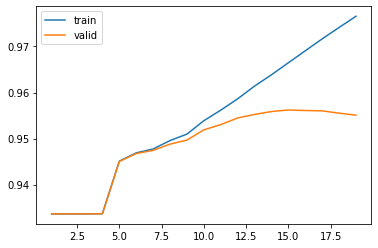

In [ ]:
# dt tunning 
max_depths = np.arange(1,20,1)
train = []
valid = []
depths = []
for x in max_depths:
    result = cross_validate(DecisionTreeClassifier(max_depth=x, random_state = 42),
                            xtrain_trans_sel,
                            y_train,
                            cv=5,
                            return_train_score= True)
    train.append(result['train_score'].mean())
    valid.append(result['test_score'].mean())
    depths.append(x)
    
sns.lineplot(x = depths, y=train, label='train')
sns.lineplot(x = depths, y=valid, label='valid')
plt.show()

max_depth = 10

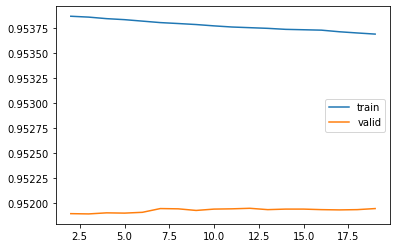

In [ ]:
min_samples_split = np.arange(2,20,1)
train = []
valid = []
a = []
for x in min_samples_split:
    result = cross_validate(DecisionTreeClassifier(max_depth=10,
                                                  min_samples_split=x, 
                                                  random_state = 42),
                            xtrain_trans_sel,
                            y_train,
                            cv=5,
                            return_train_score= True)
    train.append(result['train_score'].mean())
    valid.append(result['test_score'].mean())
    a.append(x)
    
sns.lineplot(x = a, y=train, label='train')
sns.lineplot(x = a, y=valid, label='valid')
plt.show()

min_samples_split = 10

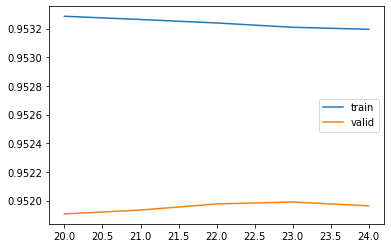

In [ ]:
min_samples_leaf = np.arange(20,25,1)
train = []
valid = []
a = []
for x in min_samples_leaf:
    result = cross_validate(DecisionTreeClassifier(max_depth=10,
                                                   min_samples_split = 10, 
                                                  min_samples_leaf=x,
                                                  random_state = 42),
                            xtrain_trans_sel,
                            y_train,
                            cv=5,
                            return_train_score= True)
    train.append(result['train_score'].mean())
    valid.append(result['test_score'].mean())
    a.append(x)
    
sns.lineplot(x = a, y=train, label='train')
sns.lineplot(x = a, y=valid, label='valid')
plt.show()

min_samples_leaf = 23

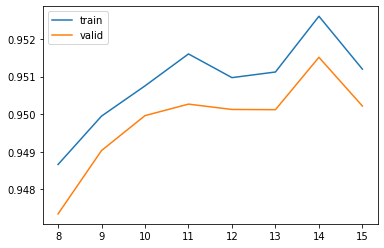

In [ ]:
max_features = np.arange(8, 16, 1)
train = []
valid = []
a = []
for x in max_features:
    result = cross_validate(DecisionTreeClassifier(max_depth = 10,
                                                  min_samples_split = 10, 
                                                  min_samples_leaf = 23,
                                                  max_features=x,
                                                  random_state = 42),
                            xtrain_trans_sel,
                            y_train,
                            cv=5,
                            return_train_score= True)
    train.append(result['train_score'].mean())
    valid.append(result['test_score'].mean())
    a.append(x)
    
sns.lineplot(x = a, y=train, label='train')
sns.lineplot(x = a, y=valid, label='valid')
plt.show()

max_features = 14

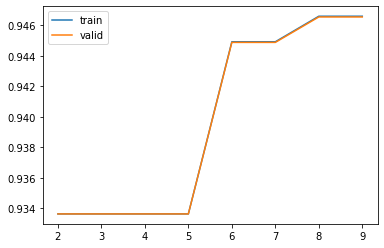

In [ ]:
max_leaf_nodes = np.arange(2,10,1)
train = []
valid = []
a = []
for x in max_leaf_nodes:
    result = cross_validate(DecisionTreeClassifier(max_depth = 10,
                                                  min_samples_split = 10, 
                                                  min_samples_leaf = 23,
                                                  max_features=14,
                                                  max_leaf_nodes = x,
                                                  random_state = 42),
                            xtrain_trans_sel,
                            y_train,
                            cv=5,
                            return_train_score= True)
    train.append(result['train_score'].mean())
    valid.append(result['test_score'].mean())
    a.append(x)
    
sns.lineplot(x = a, y=train, label='train')
sns.lineplot(x = a, y=valid, label='valid')
plt.show()

max_leaf_nodes = 3

In [ ]:
dt_opt = DecisionTreeClassifier(max_depth = 10, min_samples_split = 10, min_samples_leaf = 23, max_features=14,max_leaf_nodes = 3)
dt_opt.fit(xtrain_trans_sel, y_train)

DecisionTreeClassifier(max_depth=10, max_features=14, max_leaf_nodes=3,
                       min_samples_leaf=23, min_samples_split=10)

In [ ]:
merg([result_met(dt, xtrain_trans_sel, y_train, 'dt_train_def'),
      result_met(dt, xtest_trans_sel, y_test, 'dt_test_def'),
      result_met(dt_opt, xtrain_trans_sel, y_train, 'dt_train_opt'),
      result_met(dt_opt, xtest_trans_sel, y_test, 'dt_test_opt')])

,precision,recall,f1_score,accuracy,npv,tnr,fpr
dt_train_def,1.00,1.00,1.00,1.00,1.00,1.00,0.00
dt_test_def,0.97,0.97,0.97,0.94,0.74,0.75,0.25
dt_train_opt,0.93,1.00,0.96,0.93,1.00,0.43,0.57
dt_test_opt,0.93,1.00,0.96,0.93,1.00,0.43,0.57


**Random Forest**

In [ ]:
# rf default
rf = RandomForestClassifier()
rf.fit(xtrain_trans_sel, y_train)

RandomForestClassifier()

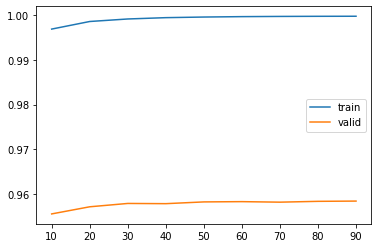

In [ ]:
# rf tunning
n_estimators = np.arange(10,100,10)
train = []
valid = []
a = []
for x in n_estimators:
    result = cross_validate(RandomForestClassifier(n_estimators=x),
                            xtrain_trans_sel,
                            y_train,
                            cv=5,
                            return_train_score= True)
    train.append(result['train_score'].mean())
    valid.append(result['test_score'].mean())
    a.append(x)
    
sns.lineplot(x = a, y=train, label='train')
sns.lineplot(x = a, y=valid, label='valid')
plt.show()

n_estimators = 60

In [ ]:
max_samples = np.arange(20000,373028,20000)
train = []
valid = []
a = []
for x in max_samples:
    result = cross_validate(RandomForestClassifier(n_estimators=60,
                                                  max_samples=x),
                            xtrain_trans_sel,
                            y_train,
                            cv=5,
                            return_train_score= True)
    train.append(result['train_score'].mean())
    valid.append(result['test_score'].mean())
    a.append(x)
    
sns.lineplot(x = a, y=train, label='train')
sns.lineplot(x = a, y=valid, label='valid')
plt.show()

max_samples = default

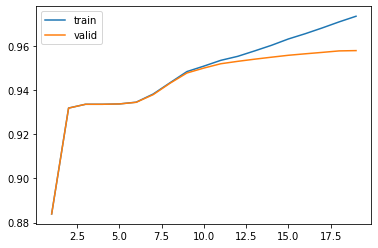

In [ ]:
max_depth = np.arange(1,20,1)
train = []
valid = []
a = []
for x in max_depth:
    result = cross_validate(RandomForestClassifier(n_estimators=60,
                                                  max_depth=x),
                            xtrain_trans_sel,
                            y_train,
                            cv=5,
                            return_train_score= True)
    train.append(result['train_score'].mean())
    valid.append(result['test_score'].mean())
    a.append(x)
    
sns.lineplot(x = a, y=train, label='train')
sns.lineplot(x = a, y=valid, label='valid')
plt.show()

max_depth = 14

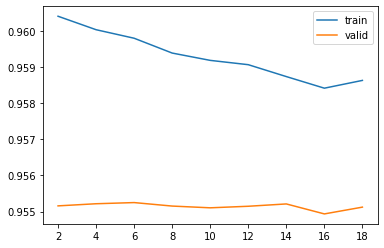

In [ ]:
min_samples_split = np.arange(2,20,2)
train = []
valid = []
a = []
for x in min_samples_split:
    result = cross_validate(RandomForestClassifier(n_estimators=60,
                                                  max_depth=14,
                                                  min_samples_split=x),
                            xtrain_trans_sel,
                            y_train,
                            cv=5,
                            return_train_score= True)
    train.append(result['train_score'].mean())
    valid.append(result['test_score'].mean())
    a.append(x)
    
sns.lineplot(x = a, y=train, label='train')
sns.lineplot(x = a, y=valid, label='valid')
plt.show()

min_samples_split = 14

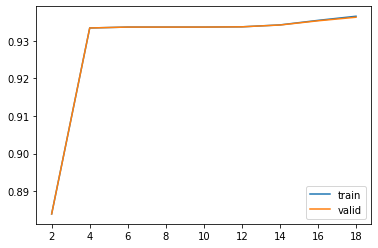

In [ ]:
max_leaf_nodes = 10,50,100
train = []
valid = []
a = []
for x in min_samples_split:
    result = cross_validate(RandomForestClassifier(n_estimators=60,
                                                  max_depth=14,
                                                  min_samples_split=14,
                                                  max_leaf_nodes = x,
                                                   random_state = 42),
                            xtrain_trans_sel,
                            y_train,
                            cv=5,
                            return_train_score= True)
    train.append(result['train_score'].mean())
    valid.append(result['test_score'].mean())
    a.append(x)
    
sns.lineplot(x = a, y=train, label='train')
sns.lineplot(x = a, y=valid, label='valid')
plt.show()

max_leaf_nodes = 4

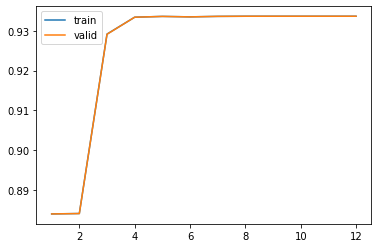

In [ ]:
max_features = np.arange(1,13,1)
train = []
valid = []
a = []
for x in max_features:
    result = cross_validate(RandomForestClassifier(n_estimators=60,
                                                  max_depth=14,
                                                  min_samples_split=14,
                                                  max_leaf_nodes = 4,
                                                  max_features = x,
                                                   random_state = 42),
                            xtrain_trans_sel,
                            y_train,
                            cv=5,
                            return_train_score= True)
    train.append(result['train_score'].mean())
    valid.append(result['test_score'].mean())
    a.append(x)
    
sns.lineplot(x = a, y=train, label='train')
sns.lineplot(x = a, y=valid, label='valid')
plt.show()

max_features = 4

In [ ]:
rf_opt = RandomForestClassifier(n_estimators=60,
                                 max_depth=14,
                                                  min_samples_split=14,
                                                  max_leaf_nodes = 4,
                                                  max_features = 4,
                                                  random_state=42)
rf_opt.fit(xtrain_trans_sel, y_train)

RandomForestClassifier(max_depth=14, max_features=4, max_leaf_nodes=4,
                       min_samples_split=14, n_estimators=60, random_state=42)

In [ ]:
merg([result_met(rf, xtrain_trans_sel, y_train, 'rf_train_def'),
      result_met(rf, xtest_trans_sel, y_test, 'rf_test_def'),
      result_met(rf_opt, xtrain_trans_sel, y_train, 'rf_train_opt'),
      result_met(rf_opt, xtest_trans_sel, y_test, 'rf_test_opt')])

,precision,recall,f1_score,accuracy,npv,tnr,fpr
rf_train_def,1.00,1.00,1.00,1.00,1.0,1.00,0.00
rf_test_def,0.96,0.99,0.98,0.96,0.9,0.72,0.28
rf_train_opt,0.93,1.00,0.96,0.93,1.0,0.43,0.57
rf_test_opt,0.93,1.00,0.96,0.93,1.0,0.43,0.57


XGBoost

In [ ]:
xgb = XGBClassifier(random_state=42)
xgb.fit(xtrain_trans_sel, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

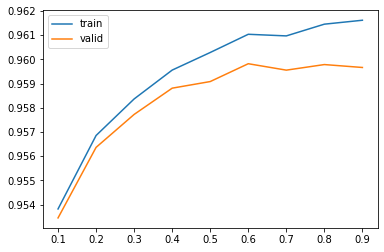

In [ ]:
learning_rate = np.arange(0.1,1,0.1)
train = []
valid = []
a = []
for x in learning_rate:
    result = cross_validate(XGBClassifier(learning_rate=x,
                                          random_state=42),
                            xtrain_trans_sel,
                            y_train,
                            cv=5,
                            return_train_score= True)
    train.append(result['train_score'].mean())
    valid.append(result['test_score'].mean())
    a.append(x)
    
sns.lineplot(x = a, y=train, label='train')
sns.lineplot(x = a, y=valid, label='valid')
plt.show()

learning_rate = 0.6

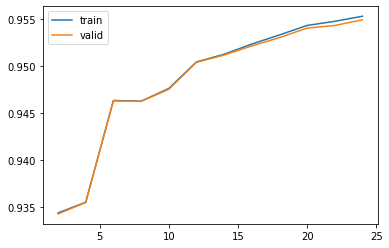

In [ ]:
n_estimators = np.arange(2,25,2)
train = []
valid = []
a = []
for x in n_estimators:
    result = cross_validate(XGBClassifier(n_estimators=x,learning_rate= 0.6, random_state=42),
                            xtrain_trans_sel,
                            y_train,
                            cv=5,
                            return_train_score= True)
    train.append(result['train_score'].mean())
    valid.append(result['test_score'].mean())
    a.append(x)
    
sns.lineplot(x = a, y=train, label='train')
sns.lineplot(x = a, y=valid, label='valid')
plt.show()

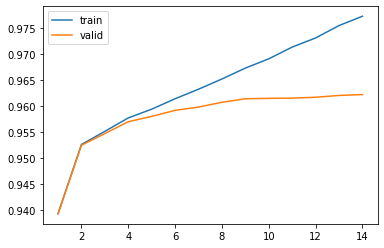

In [ ]:
max_depth = np.arange(1,15,1)
train = []
valid = []
a = []
for x in max_depth:
    result = cross_validate(XGBClassifier(n_estimators=23,
                                          learning_rate=0.6,
                                          max_depth = x,
                                          random_state=42),
                            xtrain_trans_sel,
                            y_train,
                            cv=5,
                            return_train_score= True)
    train.append(result['train_score'].mean())
    valid.append(result['test_score'].mean())
    a.append(x)
    
sns.lineplot(x = a, y=train, label='train')
sns.lineplot(x = a, y=valid, label='valid')
plt.show()

max_depth = 10

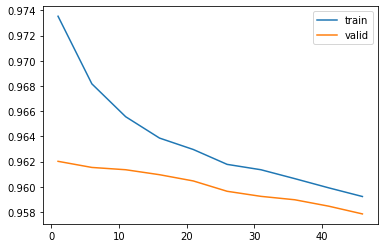

In [ ]:
gamma = np.arange(1,50,5)
train = []
valid = []
a = []
for x in gamma:
    result = cross_validate(XGBClassifier(n_estimators=23,
                                          learning_rate=0.6,
                                          max_depth = 12,
                                          gamma=x,
                                          random_state=42),
                            xtrain_trans_sel,
                            y_train,
                            cv=5,
                            return_train_score= True)
    train.append(result['train_score'].mean())
    valid.append(result['test_score'].mean())
    a.append(x)
    
sns.lineplot(x = a, y=train, label='train')
sns.lineplot(x = a, y=valid, label='valid')
plt.show()

gamma = default

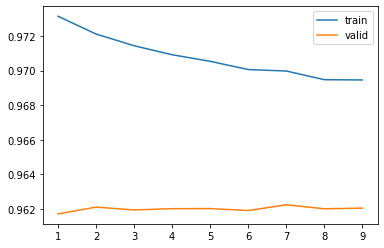

In [ ]:
reg_lambda = np.arange(1, 10, 1)
train = []
valid = []
a = []
for x in reg_lambda:
    result = cross_validate(XGBClassifier(n_estimators=23,
                                          learning_rate=0.6,
                                          max_depth = 12,
                                          reg_lambda=x,
                                          random_state=42),
                            xtrain_trans_sel,
                            y_train,
                            cv=5,
                            return_train_score= True)
    train.append(result['train_score'].mean())
    valid.append(result['test_score'].mean())
    a.append(x)
    
sns.lineplot(x = a, y=train, label='train')
sns.lineplot(x = a, y=valid, label='valid')
plt.show()

reg_lambda = 7

In [ ]:
xgb_opt = XGBClassifier(n_estimators=23,
                                          learning_rate=0.6,
                                          max_depth = 12,
                                          reg_lambda=7, random_state=42)
xgb_opt.fit(xtrain_trans_sel, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.6, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=12, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=23, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=7, ...)

In [ ]:
merg([result_met(xgb, xtrain_trans_sel, y_train, 'xgb_train_def'),
      result_met(xgb, xtest_trans_sel, y_test, 'xgb_test_def'),
      result_met(xgb_opt, xtrain_trans_sel, y_train, 'xgb_train_opt'),
      result_met(xgb_opt, xtest_trans_sel, y_test, 'xgb_test_opt')])

,precision,recall,f1_score,accuracy,npv,tnr,fpr
xgb_train_def,0.97,0.99,0.98,0.97,0.93,0.75,0.25
xgb_test_def,0.97,0.99,0.98,0.96,0.92,0.74,0.26
xgb_train_opt,0.97,0.99,0.98,0.97,0.95,0.78,0.22
xgb_test_opt,0.97,0.99,0.98,0.96,0.92,0.74,0.26


Final model xgboost 

In [ ]:
dataset.head()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-85,1.0,NaN,NaN,3.0,0.0,13648,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,Jan-15,171.62,NaN,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-11,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-99,5.0,NaN,NaN,3.0,0.0,1687,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,NaN,Sep-13,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,small_business,real estate business,606xx,IL,8.72,0.0,Nov-01,2.0,NaN,NaN,2.0,0.0,2956,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,Jun-14,649.91,NaN,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0.0,Feb-96,1.0,35.0,NaN,10.0,0.0,5598,21.0,37.0,f,0.0,0.0,12226.302210,12226.30,10000.00,2209.33,16.97,0.00,0.00,Jan-15,357.48,NaN,Jan-15,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-11,Current,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > I plan on combi...,other,Personal,972xx,OR,17.94,0.0,Jan-96,0.0,38.0,NaN,15.0,0.0,27783,53.9,38.0,f,766.9,766.9,3242.170000,3242.17,2233.10,1009.07,0.00,0.00,0.00,Jan-16,67.79,Feb-16,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
import pickle

In [ ]:
filename = 'loan_prediction.sav'
pickle.dump(xgb_opt, open(filename, 'wb'))

In [ ]:
# loading the saved model
loaded_model = pickle.load(open('loan_prediction.sav', 'rb'))

In [ ]:
clean_data = pd.concat([xtrain_trans_sel, xtest_trans_sel], axis = 0)
clean_data.shape

(466285, 17)

In [ ]:
clean_data.to_csv("loan_clean_data.csv", index = False)

In [ ]:
df.to_csv("loan_clean_data.csv", index = False)

In [ ]:
df.select_dtypes("number").head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,mnth_after_issue_d,mnth_since_last_crdt_pull,mnth_since_first_crdt
0,5000,5000,4975.0,10.65,162.87,24000.0,1,27.65,0.0,1.0,3.0,0.0,13648,83.7,9.0,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,171.62,0.0,0.0,NaN,NaN,NaN,72,22.0,394.0
1,2500,2500,2500.0,15.27,59.83,30000.0,0,1.00,0.0,5.0,3.0,0.0,1687,9.4,4.0,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,119.66,0.0,0.0,NaN,NaN,NaN,72,50.0,224.0
2,2400,2400,2400.0,15.96,84.33,12252.0,1,8.72,0.0,2.0,2.0,0.0,2956,98.5,10.0,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,649.91,0.0,0.0,NaN,NaN,NaN,72,22.0,192.0
3,10000,10000,10000.0,13.49,339.31,49200.0,1,20.00,0.0,1.0,10.0,0.0,5598,21.0,37.0,0.0,0.0,12226.302210,12226.30,10000.00,2209.33,16.97,0.00,0.00,357.48,0.0,0.0,NaN,NaN,NaN,72,34.0,261.0
4,3000,3000,3000.0,12.69,67.79,80000.0,1,17.94,0.0,0.0,15.0,0.0,27783,53.9,38.0,766.9,766.9,3242.170000,3242.17,2233.10,1009.07,0.00,0.00,0.00,67.79,0.0,0.0,NaN,NaN,NaN,72,22.0,263.0


In [ ]:
df.mnth_since_last_crdt_pull.describe()

count    466243.000000
mean         26.283457
std           9.831972
min          22.000000
25%          22.000000
50%          22.000000
75%          25.000000
max         127.000000
Name: mnth_since_last_crdt_pull, dtype: float64

In [ ]:
dataset.select_dtypes("object").head()

,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,earliest_cr_line,initial_list_status,last_pymnt_d,next_pymnt_d,last_credit_pull_d,application_type
0,36 months,B,B2,NaN,10+ years,RENT,Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,Jan-85,f,Jan-15,NaN,Jan-16,INDIVIDUAL
1,60 months,C,C4,Ryder,< 1 year,RENT,Source Verified,Dec-11,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,Apr-99,f,Apr-13,NaN,Sep-13,INDIVIDUAL
2,36 months,C,C5,NaN,10+ years,RENT,Not Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,small_business,real estate business,606xx,IL,Nov-01,f,Jun-14,NaN,Jan-16,INDIVIDUAL
3,36 months,C,C1,AIR RESOURCES BOARD,10+ years,RENT,Source Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,Feb-96,f,Jan-15,NaN,Jan-15,INDIVIDUAL
4,60 months,B,B5,University Medical Group,1 year,RENT,Source Verified,Dec-11,Current,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > I plan on combi...,other,Personal,972xx,OR,Jan-96,f,Jan-16,Feb-16,Jan-16,INDIVIDUAL


In [ ]:
xtrain_trans_sel.head()

,grade_A,grade_B,emp_length_10,home_ownership_RENT,verification_status_Not Verified,verification_status_Verified,purpose_debt_consolidation,initial_list_status_w,application_type_INDIVIDUAL,int_rate,inq_last_6mths,out_prncp_inv,total_rec_int,total_rec_late_fee,collection_recovery_fee,last_pymnt_amnt,mnth_since_last_crdt_pull
0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.300000,1.0,-0.064330,-0.609269,0.0,0.0,1.000609,4.000000
1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,-1.430909,1.0,-0.064330,-0.671012,0.0,0.0,-0.156423,7.000000
2,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,-0.121818,2.0,0.407740,0.032456,0.0,0.0,-0.072864,0.000000
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.121818,2.0,0.365736,0.775545,0.0,0.0,0.001220,2.333333
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-0.958182,1.0,1.303369,0.095587,0.0,0.0,0.029429,0.000000


In [ ]:
x_train.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,mnth_after_issue_d,mnth_since_last_crdt_pull,mnth_since_first_crdt
400718,4000,4000,4000.0,36 months,15.31,139.27,C,7,RENT,42000.0,Not Verified,debt_consolidation,14.51,0.0,1.0,11.0,1.0,2978,46.5,29.0,w,0.00,0.00,4391.190000,4391.19,4000.00,391.19,0.0,0.0,0.0,3416.30,0.0,INDIVIDUAL,0.0,53.0,13097.0,6400.0,44,34.0,230.0
16142,2700,2700,2700.0,36 months,5.79,81.89,A,8,MORTGAGE,47500.0,Not Verified,debt_consolidation,19.81,0.0,1.0,14.0,0.0,13159,18.3,32.0,f,0.00,0.00,2946.190273,2946.19,2700.00,246.19,0.0,0.0,0.0,97.20,0.0,INDIVIDUAL,0.0,NaN,NaN,NaN,80,43.0,304.0
57043,10000,10000,10000.0,36 months,12.99,336.90,B,NaN,MORTGAGE,85000.0,Verified,credit_card,13.25,0.0,2.0,17.0,0.0,19456,59.3,42.0,w,3475.74,3475.74,8422.500000,8422.50,6524.26,1898.24,0.0,0.0,0.0,336.90,0.0,INDIVIDUAL,0.0,0.0,201385.0,32800.0,48,22.0,321.0
124194,16000,16000,16000.0,36 months,14.33,549.42,C,10,MORTGAGE,185000.0,Verified,credit_card,16.78,0.0,2.0,18.0,0.0,60755,75.9,58.0,f,3166.48,3166.48,16476.860000,16476.86,12833.52,3643.34,0.0,0.0,0.0,549.42,0.0,INDIVIDUAL,0.0,0.0,119677.0,81000.0,53,29.0,438.0
393535,20000,20000,20000.0,36 months,8.39,630.34,A,0,MORTGAGE,60000.0,Source Verified,debt_consolidation,21.00,1.0,1.0,15.0,0.0,9645,68.4,25.0,f,10070.04,10070.04,11976.460000,11976.46,9929.96,2046.50,0.0,0.0,0.0,630.34,0.0,INDIVIDUAL,0.0,0.0,225610.0,14100.0,43,22.0,185.0


In [ ]:
y_train

400718    1
16142     1
57043     1
124194    1
393535    1
         ..
141463    1
55124     1
42294     0
256445    1
268616    1
Name: loan_status, Length: 373028, dtype: int64